Below is the script which takes the corrected FRAP data and analyses it by outputting the calculated radii using the most probable model. The script is using two types of fit:
1. Gradient Boosting Machine (GBM) preprocessing, followed by an exponential fitting. The preprocessing is needed as the data tends to be very noisy, so we train an ML algorithm using the actual data plus additional synthetic data (50% of the original), followed by an exponential fit.
2. Direct fit to exponential models without preprocessing.
Both methods take a very similar amount of time to be executed, hence there are no additional overheads arising from using the ML model.

Additionally, they have virtually identical residuals and goodness of fit parameters, suggesting that they are equal in their precision, however depending on the sample, they deal differently with the outliers.
In all cases, the data is fit to 1, 2 and 3 exponential models and then using statistical analysis and ranks, the best model is selected and the correct sizes are outputted on the screen.

Let's start by importing the required libraries:

We need to edit path entries in cells: [4], [9], [12], [19], [31]

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import resample
import matplotlib.pyplot as plt

Next, we define how many experimental runs there are in the data set and what are the cut-off parameters for outliers 

In [2]:
# Define the number of runs
num_runs = 10

# Define the number of standard deviations for outlier detection
num_std = 2

We also need to define the experimental parameters and some sample characteristics to get precise values for the R

In [3]:
Temperature = 293.15 # kelvin
viscosity = 0.0146 #define viscosity in Pa*s
param = 0.88 #correction factor for the gaussian beam profile
w = 10e-6 #radius of the bleaching spot
kb = 1.38e-23 # definition for Boltzmann constant
timestep = 0.2 #imaging timestep in seconds

Lastly, we need to load up an Excel spreadsheet that contains our raw data 

In [4]:
# Load the provided Excel file
file_path = r"E:\LudoxMixturesDataSheets\HSAS_70-30\5uM_R6G\FRAPCurves.xlsx"
df = pd.read_excel(file_path)

and define our exponential models:

In [5]:
# Define the exponential models
def exp_model_single(t, b0, b1, tau1):
    return b0 + b1 * (1 - np.exp(-t / tau1))

def exp_model_double(t, b0, b1, tau1, b2, tau2):
    return b0 + b1 * (1 - np.exp(-t / tau1)) + b2 * (1 - np.exp(-t / tau2))

def exp_model_triple(t, b0, b1, tau1, b2, tau2, b3, tau3):
    return b0 + b1 * (1 - np.exp(-t / tau1)) + b2 * (1 - np.exp(-t / tau2)) + b3 * (1 - np.exp(-t / tau3))

First, we start from a GBM preprocessed fitting:

In [6]:
Frame = df['Frame'].values
runs = [df[f'Run_{i}'].values for i in range(1, num_runs + 1)]

# Initialize arrays to store results for all runs
tau_single_values = np.zeros(num_runs)
A_single_values = np.zeros(num_runs)
tau_double_values = np.zeros((num_runs, 2))
A_double_values = np.zeros((num_runs, 2))
tau_triple_values = np.zeros((num_runs, 3))
A_triple_values = np.zeros((num_runs, 3))

chisq_single_values = np.zeros(num_runs)
chisq_double_values = np.zeros(num_runs)
chisq_triple_values = np.zeros(num_runs)

aicc_single_values = np.zeros(num_runs)
aicc_double_values = np.zeros(num_runs)
aicc_triple_values = np.zeros(num_runs)

for run_idx in range(num_runs):
    intensity = runs[run_idx][50:]
    time = Frame[50:]
    # Remove NaN values
    valid_mask = ~np.isnan(intensity)
    intensity = intensity[valid_mask]
    time = time[valid_mask]

    # Generate synthetic data using bootstrapping
    synthetic_time, synthetic_intensity = resample(time, intensity, n_samples=int(len(time) * 0.5), random_state=69)

    # Combine real and synthetic data
    combined_time = np.concatenate([time, synthetic_time])
    combined_intensity = np.concatenate([intensity, synthetic_intensity])

    # Gradient Boosting Machine regression on combined data
    gbm = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
    gbm.fit(combined_time.reshape(-1, 1), combined_intensity)
    predicted_intensity = gbm.predict(time.reshape(-1, 1))

    # Single exponential model fitting
    beta_single, _ = curve_fit(exp_model_single, time, predicted_intensity, p0=[min(predicted_intensity), max(predicted_intensity) - min(predicted_intensity), 100])

    # Double exponential model fitting
    beta_double, _ = curve_fit(exp_model_double, time, predicted_intensity, p0=[min(predicted_intensity), (max(predicted_intensity) - min(predicted_intensity)) / 2, 30, (max(predicted_intensity) - min(predicted_intensity)) / 2, 150])

    # Triple exponential model fitting with constraints
    bounds = (0, [300, 300, 300, 300, 300, 300, 300])
    beta_triple, _ = curve_fit(exp_model_triple, time, predicted_intensity, p0=[min(predicted_intensity), (max(predicted_intensity) - min(predicted_intensity)) / 3, 20, (max(predicted_intensity) - min(predicted_intensity)) / 3, 50, (max(predicted_intensity) - min(predicted_intensity)) / 3, 200], bounds=bounds)

    # Extract tau and A values
    tau_single = beta_single[2]
    A_single = beta_single[1]

    tau_double = np.sort([beta_double[2], beta_double[4]])
    A_double = [beta_double[1], beta_double[3]]
    A_double = np.array(A_double)[np.argsort([beta_double[2], beta_double[4]])]

    tau_triple = np.sort([beta_triple[2], beta_triple[4], beta_triple[6]])
    A_triple = [beta_triple[1], beta_triple[3], beta_triple[5]]
    A_triple = np.array(A_triple)[np.argsort([beta_triple[2], beta_triple[4], beta_triple[6]])]

    # Calculate chi-squared errors
    fitted_intensity_single = exp_model_single(time, *beta_single)
    fitted_intensity_double = exp_model_double(time, *beta_double)
    fitted_intensity_triple = exp_model_triple(time, *beta_triple)

    chisq_single = np.sum((intensity - fitted_intensity_single) ** 2)
    chisq_double = np.sum((intensity - fitted_intensity_double) ** 2)
    chisq_triple = np.sum((intensity - fitted_intensity_triple) ** 2)

    # Calculate AIC and AICc
    n = len(time)
    k_single = 3
    k_double = 5
    k_triple = 7

    aic_single = n * np.log(chisq_single / n) + 2 * k_single
    aic_double = n * np.log(chisq_double / n) + 2 * k_double
    aic_triple = n * np.log(chisq_triple / n) + 2 * k_triple

    aicc_single = aic_single + (2 * k_single ** 2 + 2 * k_single) / (n - k_single - 1)
    aicc_double = aic_double + (2 * k_double ** 2 + 2 * k_double) / (n - k_double - 1)
    aicc_triple = aic_triple + (2 * k_triple ** 2 + 2 * k_triple) / (n - k_triple - 1)

    # Store tau, A, and chi-squared values
    tau_single_values[run_idx] = tau_single
    A_single_values[run_idx] = A_single
    tau_double_values[run_idx, :] = tau_double
    A_double_values[run_idx, :] = A_double
    tau_triple_values[run_idx, :] = tau_triple
    A_triple_values[run_idx, :] = A_triple

    chisq_single_values[run_idx] = chisq_single
    chisq_double_values[run_idx] = chisq_double
    chisq_triple_values[run_idx] = chisq_triple

    aicc_single_values[run_idx] = aicc_single
    aicc_double_values[run_idx] = aicc_double
    aicc_triple_values[run_idx] = aicc_triple



Optionally, we ca plot the fit and results for each run. To do it, uncomment all of the lines below:

In [7]:

    # Display the results for the current run
#    print(f'Results for Run_{run_idx + 1}:')
#    print(f'Single Exponential: Tau = {tau_single}, A = {A_single}, Chi-squared = {chisq_single}, AICc = {aicc_single}')
#    print(f'Double Exponential: Tau = {tau_double}, A = {A_double}, Chi-squared = {chisq_double}, AICc = {aicc_double}')
#    print(f'Triple Exponential: Tau = {tau_triple}, A = {A_triple}, Chi-squared = {chisq_triple}, AICc = {aicc_triple}')

    # Plot the data and the fitted curves
#    plt.figure()
#    plt.plot(Frame, runs[run_idx], 'o', label='Data')
#    plt.plot(time, predicted_intensity, 'k-', label='GBM Predicted Intensity', linewidth=2)
#    plt.plot(time, fitted_intensity_single, '-', label='Single Exponential Fit', linewidth=2)
#    plt.plot(time, fitted_intensity_double, '--', label='Double Exponential Fit', linewidth=2)
#    plt.plot(time, fitted_intensity_triple, '-.', label='Triple Exponential Fit', linewidth=2)
#    plt.xlabel('Time')
#    plt.ylabel('Intensity')
#    plt.legend()
#    plt.title(f'Run_{run_idx + 1}: Data and Fitted Curves')
#    plt.grid(True)
#    plt.show()


Next, we will be looking for the outliers. The idea is rather simple:
1. We find the most probable value of the parameters and calculate the mean
2. If any of the parameters is 2 standard deviations away from the mean, we flag it as an outlier
3. The same is done for every model, i.e., single, double and triple exponential

In [8]:
# Combine parameters into a single array for easier processing
parameters = {
    'Tau_Single': tau_single_values,
    'A_Single': A_single_values,
    'Tau_Double1': tau_double_values[:, 0],
    'Tau_Double2': tau_double_values[:, 1],
    'A_Double1': A_double_values[:, 0],
    'A_Double2': A_double_values[:, 1],
    'Tau_Triple1': tau_triple_values[:, 0],
    'Tau_Triple2': tau_triple_values[:, 1],
    'Tau_Triple3': tau_triple_values[:, 2],
    'A_Triple1': A_triple_values[:, 0],
    'A_Triple2': A_triple_values[:, 1],
    'A_Triple3': A_triple_values[:, 2]
}

# Calculate mean and standard deviation for each parameter
mean_values = {key: np.mean(val) for key, val in parameters.items()}
std_values = {key: np.std(val) for key, val in parameters.items()}

# Detect outliers based on 2 standard deviations and additional conditions
outliers = {key: np.abs(val - mean_values[key]) > num_std * std_values[key] for key, val in parameters.items()}

# Additional conditions:
# 1. If any two tau values are equal
equal_tau_double = np.isclose(tau_double_values[:, 0], tau_double_values[:, 1])
equal_tau_triple = np.isclose(tau_triple_values[:, 0], tau_triple_values[:, 1]) | \
                   np.isclose(tau_triple_values[:, 0], tau_triple_values[:, 2]) | \
                   np.isclose(tau_triple_values[:, 1], tau_triple_values[:, 2])

# 2. If any amplitude (A) is above 1
A_above_1_single = A_single_values > 1
A_above_1_double = (A_double_values[:, 0] > 1) | (A_double_values[:, 1] > 1)
A_above_1_triple = (A_triple_values[:, 0] > 1) | (A_triple_values[:, 1] > 1) | (A_triple_values[:, 2] > 1)

# 3. If any amplitude (A) is negative
A_negative_single = A_single_values < 0
A_negative_double = (A_double_values[:, 0] < 0) | (A_double_values[:, 1] < 0)
A_negative_triple = (A_triple_values[:, 0] < 0) | (A_triple_values[:, 1] < 0) | (A_triple_values[:, 2] < 0)

# Combine all outlier conditions
outlier_runs = np.any(np.column_stack([
    outliers['Tau_Single'], 
    outliers['A_Single'], 
    outliers['Tau_Double1'], 
    outliers['Tau_Double2'], 
    outliers['A_Double1'], 
    outliers['A_Double2'], 
    outliers['Tau_Triple1'], 
    outliers['Tau_Triple2'], 
    outliers['Tau_Triple3'], 
    outliers['A_Triple1'], 
    outliers['A_Triple2'], 
    outliers['A_Triple3'],
    equal_tau_double,  # Additional condition 1: Equal Tau for double-exponential
    equal_tau_triple,  # Additional condition 1: Equal Tau for triple-exponential
    A_above_1_single,  # Additional condition 2: A > 1 for single-exponential
    A_above_1_double,  # Additional condition 2: A > 1 for double-exponential
    A_above_1_triple,  # Additional condition 2: A > 1 for triple-exponential
    A_negative_single,  # Additional condition 3: Negative A for single-exponential
    A_negative_double,  # Additional condition 3: Negative A for double-exponential
    A_negative_triple   # Additional condition 3: Negative A for triple-exponential
]), axis=1)

# Display outlier runs
print(f'Outlier Runs: {np.where(outlier_runs)[0] + 1}')

# Update summary data with the new outlier conditions and AICc values
summary_data = {
    'Run': np.arange(1, num_runs + 1),
    'Tau_Single': tau_single_values,
    'A_Single': A_single_values,
    'AICc_Single': aicc_single_values,
    'Outlier_Single': outliers['Tau_Single'] | outliers['A_Single'] | A_above_1_single | A_negative_single,
    'Tau_Double1': tau_double_values[:, 0],
    'Tau_Double2': tau_double_values[:, 1],
    'A_Double1': A_double_values[:, 0],
    'A_Double2': A_double_values[:, 1],
    'AICc_Double': aicc_double_values,
    'Outlier_Double': outliers['Tau_Double1'] | outliers['Tau_Double2'] | outliers['A_Double1'] | outliers['A_Double2'] |
                      equal_tau_double | A_above_1_double | A_negative_double,
    'Tau_Triple1': tau_triple_values[:, 0],
    'Tau_Triple2': tau_triple_values[:, 1],
    'Tau_Triple3': tau_triple_values[:, 2],
    'A_Triple1': A_triple_values[:, 0],
    'A_Triple2': A_triple_values[:, 1],
    'A_Triple3': A_triple_values[:, 2],
    'AICc_Triple': aicc_triple_values,
    'Outlier_Triple': outliers['Tau_Triple1'] | outliers['Tau_Triple2'] | outliers['Tau_Triple3'] |
                      outliers['A_Triple1'] | outliers['A_Triple2'] | outliers['A_Triple3'] |
                      equal_tau_triple | A_above_1_triple | A_negative_triple
}


Outlier Runs: [ 6 10]


Lastly, we create a summary Excel file which will be used for next steps and can also be used for any manual analysis if needed.

In [9]:
# Perform your analysis and create the summary DataFrame (assuming `summary_data` is already generated)
summary_df = pd.DataFrame(summary_data)

# Extract the directory from the file_path
directory = os.path.dirname(file_path)

# Create the new file name for the summary file
summary_file_name = "FRAP_5uM_Summary_with_Additional_Outliers.xlsx"

# Construct the full path for saving the summary file
summary_file_path = os.path.join(directory, summary_file_name)

# Save the summary table to the new Excel file
summary_df.to_excel(summary_file_path, index=False)

Now, for comparison, we will do the same, but using a direct fitting to exponential models, without GBM preprocessing part:

In [10]:
# Initialize arrays to store results for all runs
tau_single_values_direct = np.zeros(num_runs)
A_single_values_direct = np.zeros(num_runs)
tau_double_values_direct = np.zeros((num_runs, 2))
A_double_values_direct = np.zeros((num_runs, 2))
tau_triple_values_direct = np.zeros((num_runs, 3))
A_triple_values_direct = np.zeros((num_runs, 3))

chisq_single_values_direct = np.zeros(num_runs)
chisq_double_values_direct = np.zeros(num_runs)
chisq_triple_values_direct = np.zeros(num_runs)

aicc_single_values_direct = np.zeros(num_runs)
aicc_double_values_direct = np.zeros(num_runs)
aicc_triple_values_direct = np.zeros(num_runs)

for run_idx in range(num_runs):
    intensity = runs[run_idx][50:]
    time = Frame[50:]
    # Remove NaN values
    valid_mask = ~np.isnan(intensity)
    intensity = intensity[valid_mask]
    time = time[valid_mask]

    # Direct exponential model fitting without GBM

    # Single exponential model fitting
    beta_single_direct, _ = curve_fit(exp_model_single, time, intensity, p0=[min(intensity), max(intensity) - min(intensity), 100])

    # Double exponential model fitting
    beta_double_direct, _ = curve_fit(exp_model_double, time, intensity, p0=[min(intensity), (max(intensity) - min(intensity)) / 2, 30, (max(intensity) - min(intensity)) / 2, 150])

    # Triple exponential model fitting with constraints
    bounds = (0, [300, 300, 300, 300, 300, 300, 300])
    beta_triple_direct, _ = curve_fit(exp_model_triple, time, intensity, p0=[min(intensity), (max(intensity) - min(intensity)) / 3, 20, (max(intensity) - min(intensity)) / 3, 50, (max(intensity) - min(intensity)) / 3, 200], bounds=bounds)

    # Extract tau and A values
    tau_single_direct = beta_single_direct[2]
    A_single_direct = beta_single_direct[1]

    tau_double_direct = np.sort([beta_double_direct[2], beta_double_direct[4]])
    A_double_direct = [beta_double_direct[1], beta_double_direct[3]]
    A_double_direct = np.array(A_double_direct)[np.argsort([beta_double_direct[2], beta_double_direct[4]])]

    tau_triple_direct = np.sort([beta_triple_direct[2], beta_triple_direct[4], beta_triple_direct[6]])
    A_triple_direct = [beta_triple_direct[1], beta_triple_direct[3], beta_triple_direct[5]]
    A_triple_direct = np.array(A_triple_direct)[np.argsort([beta_triple_direct[2], beta_triple_direct[4], beta_triple_direct[6]])]

    # Calculate chi-squared errors for direct fitting
    fitted_intensity_single_direct = exp_model_single(time, *beta_single_direct)
    fitted_intensity_double_direct = exp_model_double(time, *beta_double_direct)
    fitted_intensity_triple_direct = exp_model_triple(time, *beta_triple_direct)

    chisq_single_direct = np.sum((intensity - fitted_intensity_single_direct) ** 2)
    chisq_double_direct = np.sum((intensity - fitted_intensity_double_direct) ** 2)
    chisq_triple_direct = np.sum((intensity - fitted_intensity_triple_direct) ** 2)

    # Calculate AIC and AICc for direct fitting
    n = len(time)
    k_single = 3
    k_double = 5
    k_triple = 7

    aic_single_direct = n * np.log(chisq_single_direct / n) + 2 * k_single
    aic_double_direct = n * np.log(chisq_double_direct / n) + 2 * k_double
    aic_triple_direct = n * np.log(chisq_triple_direct / n) + 2 * k_triple

    aicc_single_direct = aic_single_direct + (2 * k_single ** 2 + 2 * k_single) / (n - k_single - 1)
    aicc_double_direct = aic_double_direct + (2 * k_double ** 2 + 2 * k_double) / (n - k_double - 1)
    aicc_triple_direct = aic_triple_direct + (2 * k_triple ** 2 + 2 * k_triple) / (n - k_triple - 1)

    # Store tau, A, and chi-squared values for direct fitting
    tau_single_values_direct[run_idx] = tau_single_direct
    A_single_values_direct[run_idx] = A_single_direct
    tau_double_values_direct[run_idx, :] = tau_double_direct
    A_double_values_direct[run_idx, :] = A_double_direct
    tau_triple_values_direct[run_idx, :] = tau_triple_direct
    A_triple_values_direct[run_idx, :] = A_triple_direct

    chisq_single_values_direct[run_idx] = chisq_single_direct
    chisq_double_values_direct[run_idx] = chisq_double_direct
    chisq_triple_values_direct[run_idx] = chisq_triple_direct

    aicc_single_values_direct[run_idx] = aicc_single_direct
    aicc_double_values_direct[run_idx] = aicc_double_direct
    aicc_triple_values_direct[run_idx] = aicc_triple_direct
    



And we also look for outliers using the exact same method as before:

In [11]:

# Create a dictionary with parameters for outlier detection
parameters = {
    'Tau_Single_Direct': tau_single_values_direct,
    'A_Single_Direct': A_single_values_direct,
    'Tau_Double1_Direct': tau_double_values_direct[:, 0],
    'Tau_Double2_Direct': tau_double_values_direct[:, 1],
    'A_Double1_Direct': A_double_values_direct[:, 0],
    'A_Double2_Direct': A_double_values_direct[:, 1],
    'Tau_Triple1_Direct': tau_triple_values_direct[:, 0],
    'Tau_Triple2_Direct': tau_triple_values_direct[:, 1],
    'Tau_Triple3_Direct': tau_triple_values_direct[:, 2],
    'A_Triple1_Direct': A_triple_values_direct[:, 0],
    'A_Triple2_Direct': A_triple_values_direct[:, 1],
    'A_Triple3_Direct': A_triple_values_direct[:, 2]
}

# Calculate mean and standard deviation for each parameter
mean_values = {key: np.mean(val) for key, val in parameters.items()}
std_values = {key: np.std(val) for key, val in parameters.items()}

# Detect outliers based on 2 standard deviations and additional conditions
outliers_direct = {key: np.abs(val - mean_values[key]) > num_std * std_values[key] for key, val in parameters.items()}

# Additional conditions
equal_tau_double_direct = np.isclose(parameters['Tau_Double1_Direct'], parameters['Tau_Double2_Direct'])
equal_tau_triple_direct = np.isclose(parameters['Tau_Triple1_Direct'], parameters['Tau_Triple2_Direct']) | \
                          np.isclose(parameters['Tau_Triple1_Direct'], parameters['Tau_Triple3_Direct']) | \
                          np.isclose(parameters['Tau_Triple2_Direct'], parameters['Tau_Triple3_Direct'])

A_above_1_single_direct = parameters['A_Single_Direct'] > 1
A_above_1_double_direct = (parameters['A_Double1_Direct'] > 1) | (parameters['A_Double2_Direct'] > 1)
A_above_1_triple_direct = (parameters['A_Triple1_Direct'] > 1) | (parameters['A_Triple2_Direct'] > 1) | (parameters['A_Triple3_Direct'] > 1)

A_negative_single_direct = parameters['A_Single_Direct'] < 0
A_negative_double_direct = (parameters['A_Double1_Direct'] < 0) | (parameters['A_Double2_Direct'] < 0)
A_negative_triple_direct = (parameters['A_Triple1_Direct'] < 0) | (parameters['A_Triple2_Direct'] < 0) | (parameters['A_Triple3_Direct'] < 0)

# Combine all outlier conditions
outlier_runs_direct = np.any(np.column_stack([
    outliers_direct['Tau_Single_Direct'], 
    outliers_direct['A_Single_Direct'], 
    outliers_direct['Tau_Double1_Direct'], 
    outliers_direct['Tau_Double2_Direct'], 
    outliers_direct['A_Double1_Direct'], 
    outliers_direct['A_Double2_Direct'], 
    outliers_direct['Tau_Triple1_Direct'], 
    outliers_direct['Tau_Triple2_Direct'], 
    outliers_direct['Tau_Triple3_Direct'], 
    outliers_direct['A_Triple1_Direct'], 
    outliers_direct['A_Triple2_Direct'], 
    outliers_direct['A_Triple3_Direct'],
    equal_tau_double_direct,  # Additional condition 1: Equal Tau for double-exponential
    equal_tau_triple_direct,  # Additional condition 1: Equal Tau for triple-exponential
    A_above_1_single_direct,  # Additional condition 2: A > 1 for single-exponential
    A_above_1_double_direct,  # Additional condition 2: A > 1 for double-exponential
    A_above_1_triple_direct,  # Additional condition 2: A > 1 for triple-exponential
    A_negative_single_direct,  # Additional condition 3: Negative A for single-exponential
    A_negative_double_direct,  # Additional condition 3: Negative A for double-exponential
    A_negative_triple_direct   # Additional condition 3: Negative A for triple-exponential
]), axis=1)

# Display outlier runs
print(f'Outlier Runs: {np.where(outlier_runs_direct)[0] + 1}')
# Update summary data with the new outlier conditions and AICc values
summary_data_direct = {
    'Run': np.arange(1, num_runs + 1),
    'Tau_Single_Direct': tau_single_values_direct,
    'A_Single_Direct': A_single_values_direct,
    'AICc_Single_Direct': aicc_single_values_direct,  # Add AICc Single
    'Outlier_Single_Direct': outliers_direct['Tau_Single_Direct'] | outliers_direct['A_Single_Direct'] | A_above_1_single_direct | A_negative_single_direct,
    'Tau_Double1_Direct': tau_double_values_direct[:, 0],
    'Tau_Double2_Direct': tau_double_values_direct[:, 1],
    'A_Double1_Direct': A_double_values_direct[:, 0],
    'A_Double2_Direct': A_double_values_direct[:, 1],
    'AICc_Double_Direct': aicc_double_values_direct,  # Add AICc Double
    'Outlier_Double_Direct': outliers_direct['Tau_Double1_Direct'] | outliers_direct['Tau_Double2_Direct'] | outliers_direct['A_Double1_Direct'] | outliers_direct['A_Double2_Direct'] |
                             equal_tau_double_direct | A_above_1_double_direct | A_negative_double_direct,
    'Tau_Triple1_Direct': tau_triple_values_direct[:, 0],
    'Tau_Triple2_Direct': tau_triple_values_direct[:, 1],
    'Tau_Triple3_Direct': tau_triple_values_direct[:, 2],
    'A_Triple1_Direct': A_triple_values_direct[:, 0],
    'A_Triple2_Direct': A_triple_values_direct[:, 1],
    'A_Triple3_Direct': A_triple_values_direct[:, 2],
    'AICc_Triple_Direct': aicc_triple_values_direct,  # Add AICc Triple
    'Outlier_Triple_Direct': outliers_direct['Tau_Triple1_Direct'] | outliers_direct['Tau_Triple2_Direct'] | outliers_direct['Tau_Triple3_Direct'] |
                             outliers_direct['A_Triple1_Direct'] | outliers_direct['A_Triple2_Direct'] | outliers_direct['A_Triple3_Direct'] |
                             equal_tau_triple_direct | A_above_1_triple_direct | A_negative_triple_direct
}


Outlier Runs: [ 6 10]


And generate a summary table

In [12]:

# Assuming summary_data_direct is already generated
summary_df_direct = pd.DataFrame(summary_data_direct)

# Extract the directory from the original file path
file_path = r"E:\LudoxMixturesDataSheets\HSAS_70-30\5uM_R6G\FRAPCurves.xlsx"
directory = os.path.dirname(file_path)

# Create the new file name for the summary file
summary_file_name = "FRAP_5uM_Summary_with_Additional_Outliers_Direct.xlsx"

# Construct the full path for saving the summary file
summary_file_path = os.path.join(directory, summary_file_name)

# Save the summary table to the new Excel file
summary_df_direct.to_excel(summary_file_path, index=False)

# Display the summary table
print(summary_df_direct)


   Run  Tau_Single_Direct  A_Single_Direct  AICc_Single_Direct  \
0    1         132.930749         0.246443        -6193.730231   
1    2         136.481964         0.199263        -6491.071279   
2    3         118.503471         0.274347        -6202.641740   
3    4         139.441968         0.184889        -6160.938883   
4    5         120.980383         0.236275        -6214.087764   
5    6         131.626991         0.212764        -6035.256071   
6    7         113.860595         0.192791        -6116.695557   
7    8         125.759229         0.175767        -6401.192978   
8    9         138.629584         0.197616        -6223.127437   
9   10         148.586197         0.154254        -6371.085482   

   Outlier_Single_Direct  Tau_Double1_Direct  Tau_Double2_Direct  \
0                  False           33.177555          162.064777   
1                  False           23.808956          154.672306   
2                  False           26.531434          137.778673   
3

Now that the data is fitted, we ignore the outliers and focus on the good data only for all future steps.

First, we convert the recovered Tau values into recovery half times by multiplying them by ln(2) and by our imaging timestep:

In [13]:
# Extract non-outlier indices for each model
non_outlier_single = ~outliers['Tau_Single'] & ~A_above_1_single & ~A_negative_single
non_outlier_double1 = ~outliers['Tau_Double1'] & ~A_above_1_double & ~A_negative_double & ~equal_tau_double
non_outlier_double2 = ~outliers['Tau_Double2'] & ~A_above_1_double & ~A_negative_double & ~equal_tau_double
non_outlier_triple1 = ~outliers['Tau_Triple1'] & ~A_above_1_triple & ~A_negative_triple & ~equal_tau_triple
non_outlier_triple2 = ~outliers['Tau_Triple2'] & ~A_above_1_triple & ~A_negative_triple & ~equal_tau_triple
non_outlier_triple3 = ~outliers['Tau_Triple3'] & ~A_above_1_triple & ~A_negative_triple & ~equal_tau_triple

# Perform the calculations for each model component
tau_single_non_outlier = tau_single_values[non_outlier_single]
tau_double1_non_outlier = tau_double_values[non_outlier_double1, 0]
tau_double2_non_outlier = tau_double_values[non_outlier_double2, 1]
tau_triple1_non_outlier = tau_triple_values[non_outlier_triple1, 0]
tau_triple2_non_outlier = tau_triple_values[non_outlier_triple2, 1]
tau_triple3_non_outlier = tau_triple_values[non_outlier_triple3, 2]

# Calculate T * ln(2) * timestep
ln2 = np.log(2)
result_single = tau_single_non_outlier * ln2 * timestep
result_double1 = tau_double1_non_outlier * ln2 * timestep
result_double2 = tau_double2_non_outlier * ln2 * timestep
result_triple1 = tau_triple1_non_outlier * ln2 * timestep
result_triple2 = tau_triple2_non_outlier * ln2 * timestep
result_triple3 = tau_triple3_non_outlier * ln2 * timestep

# Print results
print("Single Exponential T values (non-outliers):")
print(result_single)

print("Double Exponential T values (non-outliers) - Tau1:")
print(result_double1)

print("Double Exponential T values (non-outliers) - Tau2:")
print(result_double2)

print("Triple Exponential T values (non-outliers) - Tau1:")
print(result_triple1)

print("Triple Exponential T values (non-outliers) - Tau2:")
print(result_triple2)

print("Triple Exponential T values (non-outliers) - Tau3:")
print(result_triple3)


Single Exponential T values (non-outliers):
[18.42877019 18.93982841 16.42931087 19.35397049 16.7695222  18.2467805
 15.78335152 17.42145682 19.2279738  20.62600554]
Double Exponential T values (non-outliers) - Tau1:
[4.63465204 3.29046032 3.72819189 6.1751397  3.94276124 3.66069701
 6.0194369  3.89655432 4.69653188 5.26459752]
Double Exponential T values (non-outliers) - Tau2:
[22.50885647 21.46778371 19.13432649 29.6538688  20.27565871 23.27104562
 25.53930516 21.26451393 24.93112404 28.12494485]
Triple Exponential T values (non-outliers) - Tau1:
[2.75669942 2.18528914 1.82926322 0.47126903 1.57224114 3.18930061
 1.40588167 3.59579192 2.42847484]
Triple Exponential T values (non-outliers) - Tau2:
[14.99149525 16.5655998   9.42787458  6.17522415  5.48669006 18.05768944
  7.19644008 19.01835842 11.35886715]
Triple Exponential T values (non-outliers) - Tau3:
[41.58883083 41.58883083 22.22840726 29.65409921 20.97739447 41.58883083
 28.02632125 41.58883083 32.90602836 28.13449042]


And do the same for the direct fit as well:

In [14]:
# Extract non-outlier indices for each model (Directed fits)
non_outlier_single_direct = ~outliers_direct['Tau_Single_Direct'] & ~A_above_1_single_direct & ~A_negative_single_direct
non_outlier_double1_direct = ~outliers_direct['Tau_Double1_Direct'] & ~A_above_1_double_direct & ~A_negative_double_direct & ~equal_tau_double_direct
non_outlier_double2_direct = ~outliers_direct['Tau_Double2_Direct'] & ~A_above_1_double_direct & ~A_negative_double_direct & ~equal_tau_double_direct
non_outlier_triple1_direct = ~outliers_direct['Tau_Triple1_Direct'] & ~A_above_1_triple_direct & ~A_negative_triple_direct & ~equal_tau_triple_direct
non_outlier_triple2_direct = ~outliers_direct['Tau_Triple2_Direct'] & ~A_above_1_triple_direct & ~A_negative_triple_direct & ~equal_tau_triple_direct
non_outlier_triple3_direct = ~outliers_direct['Tau_Triple3_Direct'] & ~A_above_1_triple_direct & ~A_negative_triple_direct & ~equal_tau_triple_direct

# Perform the calculations for each model component (Directed fits)
tau_single_direct_non_outlier = tau_single_values_direct[non_outlier_single_direct]
tau_double1_direct_non_outlier = tau_double_values_direct[non_outlier_double1_direct, 0]
tau_double2_direct_non_outlier = tau_double_values_direct[non_outlier_double2_direct, 1]
tau_triple1_direct_non_outlier = tau_triple_values_direct[non_outlier_triple1_direct, 0]
tau_triple2_direct_non_outlier = tau_triple_values_direct[non_outlier_triple2_direct, 1]
tau_triple3_direct_non_outlier = tau_triple_values_direct[non_outlier_triple3_direct, 2]

# Calculate T * ln(2) * timestep for Directed fits
ln2 = np.log(2)
result_single_direct = tau_single_direct_non_outlier * ln2 * timestep
result_double1_direct = tau_double1_direct_non_outlier * ln2 * timestep
result_double2_direct = tau_double2_direct_non_outlier * ln2 * timestep
result_triple1_direct = tau_triple1_direct_non_outlier * ln2 * timestep
result_triple2_direct = tau_triple2_direct_non_outlier * ln2 * timestep
result_triple3_direct = tau_triple3_direct_non_outlier * ln2 * timestep

# Print results for Directed fits
print("Single Exponential T values (non-outliers) - Directed:")
print(result_single_direct)

print("Double Exponential T values (non-outliers) - Directed - Tau1:")
print(result_double1_direct)

print("Double Exponential T values (non-outliers) - Directed - Tau2:")
print(result_double2_direct)

print("Triple Exponential T values (non-outliers) - Directed - Tau1:")
print(result_triple1_direct)

print("Triple Exponential T values (non-outliers) - Directed - Tau2:")
print(result_triple2_direct)

print("Triple Exponential T values (non-outliers) - Directed - Tau3:")
print(result_triple3_direct)


Single Exponential T values (non-outliers) - Directed:
[18.42811477 18.92041771 16.42806938 19.33076134 16.77144233 18.2473756
 15.78443006 17.43393105 19.21814108 20.59842071]
Double Exponential T values (non-outliers) - Directed - Tau1:
[4.59938569 3.30062218 3.67803773 6.16693047 3.96174397 3.65291745
 5.99671692 3.87093272 4.71277861 5.30811183]
Double Exponential T values (non-outliers) - Directed - Tau2:
[22.46694867 21.4421346  19.10017973 29.57254253 20.29837479 23.2653179
 25.48924785 21.28801125 24.94879207 28.16874039]
Triple Exponential T values (non-outliers) - Directed - Tau1:
[2.74598928 2.15458831 1.84319309 1.48840963 1.59003307 3.17151427
 1.41011561 3.64058739 2.412164  ]
Triple Exponential T values (non-outliers) - Directed - Tau2:
[15.01659179 16.48102658  9.84759822  8.37565373  5.65924501 17.98525975
  7.18837349 19.47842712 11.00803075 19.86895313]
Triple Exponential T values (non-outliers) - Directed - Tau3:
[41.58883083 41.58882747 22.61818729 34.09708357 21.0

Next, we calculate the diffusion coefficients for both.
First we do the DBM pre-processed model:

In [15]:

# Calculate diffusion coefficients using the non-outlier values
D_single = param * ((w ** 2) / (4 * result_single))
D_double1 = param * (w ** 2) / (4 * result_double1)
D_double2 = param * (w ** 2) / (4 * result_double2)
D_triple1 = param * (w ** 2) / (4 * result_triple1)
D_triple2 = param * (w ** 2) / (4 * result_triple2)
D_triple3 = param * (w ** 2) / (4 * result_triple3)

# Print diffusion coefficients
print("Diffusion Coefficients for Single Exponential (non-outliers):")
print(D_single)

print("Diffusion Coefficients for Double Exponential (non-outliers) - Tau1:")
print(D_double1)

print("Diffusion Coefficients for Double Exponential (non-outliers) - Tau2:")
print(D_double2)

print("Diffusion Coefficients for Triple Exponential (non-outliers) - Tau1:")
print(D_triple1)

print("Diffusion Coefficients for Triple Exponential (non-outliers) - Tau2:")
print(D_triple2)

print("Diffusion Coefficients for Triple Exponential (non-outliers) - Tau3:")
print(D_triple3)


Diffusion Coefficients for Single Exponential (non-outliers):
[1.19378557e-12 1.16157335e-12 1.33907016e-12 1.13671766e-12
 1.31190381e-12 1.20569215e-12 1.39387379e-12 1.26281058e-12
 1.14416632e-12 1.06661467e-12]
Diffusion Coefficients for Double Exponential (non-outliers) - Tau1:
[4.74685043e-12 6.68599463e-12 5.90098382e-12 3.56267244e-12
 5.57984587e-12 6.00978446e-12 3.65482692e-12 5.64601393e-12
 4.68430760e-12 4.17885696e-12]
Diffusion Coefficients for Double Exponential (non-outliers) - Tau2:
[9.77393055e-13 1.02479139e-12 1.14976610e-12 7.41893078e-13
 1.08504490e-12 9.45380812e-13 8.61417328e-13 1.03458749e-12
 8.82431132e-13 7.82223756e-13]
Diffusion Coefficients for Triple Exponential (non-outliers) - Tau1:
[7.98055814e-12 1.00673177e-11 1.20267000e-11 4.66824655e-11
 1.39927645e-11 6.89806409e-12 1.56485431e-11 6.11826281e-12
 9.05918382e-12]
Diffusion Coefficients for Triple Exponential (non-outliers) - Tau2:
[1.46749871e-12 1.32805333e-12 2.33350580e-12 3.56262372e-12


And for the direct fittings:

In [16]:
# Calculate diffusion coefficients using the non-outlier values from Direct Fitting
D_single_direct = param * ((w ** 2) / (4 * result_single_direct))
D_double1_direct = param * (w ** 2) / (4 * result_double1_direct)
D_double2_direct = param * (w ** 2) / (4 * result_double2_direct)
D_triple1_direct = param * (w ** 2) / (4 * result_triple1_direct)
D_triple2_direct = param * (w ** 2) / (4 * result_triple2_direct)
D_triple3_direct = param * (w ** 2) / (4 * result_triple3_direct)

# Print diffusion coefficients for Direct Fitting
print("Diffusion Coefficients for Single Exponential (non-outliers) - Direct:")
print(D_single_direct)

print("Diffusion Coefficients for Double Exponential (non-outliers) - Tau1 - Direct:")
print(D_double1_direct)

print("Diffusion Coefficients for Double Exponential (non-outliers) - Tau2 - Direct:")
print(D_double2_direct)

print("Diffusion Coefficients for Triple Exponential (non-outliers) - Tau1 - Direct:")
print(D_triple1_direct)

print("Diffusion Coefficients for Triple Exponential (non-outliers) - Tau2 - Direct:")
print(D_triple2_direct)

print("Diffusion Coefficients for Triple Exponential (non-outliers) - Tau3 - Direct:")
print(D_triple3_direct)


Diffusion Coefficients for Single Exponential (non-outliers) - Direct:
[1.19382803e-12 1.16276503e-12 1.33917136e-12 1.13808244e-12
 1.31175361e-12 1.20565283e-12 1.39377855e-12 1.26190702e-12
 1.14475172e-12 1.06804305e-12]
Diffusion Coefficients for Double Exponential (non-outliers) - Tau1 - Direct:
[4.78324748e-12 6.66540998e-12 5.98145032e-12 3.56741496e-12
 5.55310998e-12 6.02258340e-12 3.66867409e-12 5.68338475e-12
 4.66815902e-12 4.14459995e-12]
Diffusion Coefficients for Double Exponential (non-outliers) - Tau2 - Direct:
[9.79216195e-13 1.02601725e-12 1.15182162e-12 7.43933329e-13
 1.08383061e-12 9.45613556e-13 8.63109031e-13 1.03344553e-12
 8.81806219e-13 7.81007588e-13]
Diffusion Coefficients for Triple Exponential (non-outliers) - Tau1 - Direct:
[8.01168460e-12 1.02107674e-11 1.19358086e-11 1.47808773e-11
 1.38361902e-11 6.93674949e-12 1.56015576e-11 6.04298089e-12
 9.12044123e-12]
Diffusion Coefficients for Triple Exponential (non-outliers) - Tau2 - Direct:
[1.46504615e-12 

Lastly, we calculate the hydrodynamic radius in every non-outlier case, starting with the GBM pre-processed model:

In [17]:
# Calculate particle sizes using the diffusion coefficients
R_single = (kb * Temperature) / (6 * np.pi * viscosity * D_single) / 1e-9
R_double1 = (kb * Temperature) / (6 * np.pi * viscosity * D_double1) / 1e-9
R_double2 = (kb * Temperature) / (6 * np.pi * viscosity * D_double2) / 1e-9
R_triple1 = (kb * Temperature) / (6 * np.pi * viscosity * D_triple1) / 1e-9
R_triple2 = (kb * Temperature) / (6 * np.pi * viscosity * D_triple2) / 1e-9
R_triple3 = (kb * Temperature) / (6 * np.pi * viscosity * D_triple3) / 1e-9

# Print particle sizes
print("Particle Sizes for Single Exponential (non-outliers):")
print(R_single)

print("Particle Sizes for Double Exponential (non-outliers) - Tau1:")
print(R_double1)

print("Particle Sizes for Double Exponential (non-outliers) - Tau2:")
print(R_double2)

print("Particle Sizes for Triple Exponential (non-outliers) - Tau1:")
print(R_triple1)

print("Particle Sizes for Triple Exponential (non-outliers) - Tau2:")
print(R_triple2)

print("Particle Sizes for Triple Exponential (non-outliers) - Tau3:")
print(R_triple3)


Particle Sizes for Single Exponential (non-outliers):
[12.31370315 12.65518113 10.97770795 12.93190185 11.20502975 12.1921016
 10.54609197 11.64063828 12.8477136  13.78184799]
Particle Sizes for Double Exponential (non-outliers) - Tau1:
[3.09677362 2.19861397 2.49109668 4.12609395 2.63446725 2.44599807
 4.02205672 2.60359279 3.13812039 3.51768948]
Particle Sizes for Double Exponential (non-outliers) - Tau2:
[15.039928   14.34430584 12.78514051 19.81406973 13.54775386 15.54920619
 17.06480786 14.2084854  16.65843447 18.79247602]
Particle Sizes for Triple Exponential (non-outliers) - Tau1:
[1.84196655 1.46016264 1.22227387 0.31489171 1.05053731 2.13102125
 0.93937954 2.4026299  1.62265403]
Particle Sizes for Triple Exponential (non-outliers) - Tau2:
[10.01699084 11.06877325  6.2995006   4.12615037  3.66608688 12.06575507
  4.80850463 12.70765317  7.58974781]
Particle Sizes for Triple Exponential (non-outliers) - Tau3:
[27.7887516  27.78875159 14.85253794 19.81422368 14.01663842 27.788751

And now do the same for the direct fitting:

In [18]:
# a quick reminder:
# Constants (Ensure these are defined beforehand)
# kb = Boltzmann constant
# Temperature = system temperature (in Kelvin)
# viscosity = viscosity of the medium (in Pa.s or equivalent)

# Calculate particle sizes using the diffusion coefficients from Direct Fitting
R_single_direct = (kb * Temperature) / (6 * np.pi * viscosity * D_single_direct) / 1e-9
R_double1_direct = (kb * Temperature) / (6 * np.pi * viscosity * D_double1_direct) / 1e-9
R_double2_direct = (kb * Temperature) / (6 * np.pi * viscosity * D_double2_direct) / 1e-9
R_triple1_direct = (kb * Temperature) / (6 * np.pi * viscosity * D_triple1_direct) / 1e-9
R_triple2_direct = (kb * Temperature) / (6 * np.pi * viscosity * D_triple2_direct) / 1e-9
R_triple3_direct = (kb * Temperature) / (6 * np.pi * viscosity * D_triple3_direct) / 1e-9

# Print particle sizes for Direct Fitting
print("Particle Sizes for Single Exponential (non-outliers) - Direct:")
print(R_single_direct)

print("Particle Sizes for Double Exponential (non-outliers) - Tau1 - Direct:")
print(R_double1_direct)

print("Particle Sizes for Double Exponential (non-outliers) - Tau2 - Direct:")
print(R_double2_direct)

print("Particle Sizes for Triple Exponential (non-outliers) - Tau1 - Direct:")
print(R_triple1_direct)

print("Particle Sizes for Triple Exponential (non-outliers) - Tau2 - Direct:")
print(R_triple2_direct)

print("Particle Sizes for Triple Exponential (non-outliers) - Tau3 - Direct:")
print(R_triple3_direct)


Particle Sizes for Single Exponential (non-outliers) - Direct:
[12.31326521 12.64221132 10.97687841 12.916394   11.20631274 12.19249923
 10.54681262 11.64897328 12.84114359 13.7634164 ]
Particle Sizes for Double Exponential (non-outliers) - Tau1 - Direct:
[3.07320941 2.2054039  2.45758476 4.12060872 2.6471511  2.44079994
 4.00687573 2.58647299 3.1489761  3.54676479]
Particle Sizes for Double Exponential (non-outliers) - Tau2 - Direct:
[15.01192612 14.32716766 12.76232439 19.75972928 13.56293225 15.54537906
 17.03136065 14.22418579 16.67023986 18.82173925]
Particle Sizes for Triple Exponential (non-outliers) - Tau1 - Direct:
[1.83481027 1.43964902 1.23158151 0.99452292 1.06242549 2.11913681
 0.94220856 2.43256126 1.61175549]
Particle Sizes for Triple Exponential (non-outliers) - Tau2 - Direct:
[10.0337598  11.01226326  6.5799508   5.59642953  3.78138434 12.01735912
  4.80311471 13.01506106  7.35532656 13.27600204]
Particle Sizes for Triple Exponential (non-outliers) - Tau3 - Direct:
[27

Now, we have fitted all of the data set using a total of six models:

1. GBM Single-Exponential
2. GBM Double-Exponential
3. GBM Triple-Exponential
4. Direct Single-Exponential
5. Direct Double-Exponential
6. Direct Triple-Exponential

Now we need to identify which model is the best and plot the results. To do this, we will be using AICc, Standard Deviation and the Likelihood ratio test. 

Let's calculate all of that step by step:

First lest rank the models based on the average AIC results after excluding the outliers:

In [19]:

# Load the summary data for GBM and direct fitting
summary_df = pd.read_excel(r"E:\LudoxMixturesDataSheets\HSAS_70-30\5uM_R6G\FRAP_5uM_Summary_with_Additional_Outliers.xlsx")
summary_df_direct = pd.read_excel(r"E:\LudoxMixturesDataSheets\HSAS_70-30\5uM_R6G\FRAP_5uM_Summary_with_Additional_Outliers_Direct.xlsx")

# Filter out the non-outlier data
non_outlier_df = summary_df[~summary_df['Outlier_Single']]
non_outlier_df_direct = summary_df_direct[~summary_df_direct['Outlier_Single_Direct']]

# Calculate the mean AIC values for non-outlier data
mean_aic_single = non_outlier_df['AICc_Single'].mean()
mean_aic_double = non_outlier_df['AICc_Double'].mean()
mean_aic_triple = non_outlier_df['AICc_Triple'].mean()

mean_aic_single_direct = non_outlier_df_direct['AICc_Single_Direct'].mean()
mean_aic_double_direct = non_outlier_df_direct['AICc_Double_Direct'].mean()
mean_aic_triple_direct = non_outlier_df_direct['AICc_Triple_Direct'].mean()

# Compare models based on mean AIC values
aic_values = {
    'GBM_Single': mean_aic_single,
    'GBM_Double': mean_aic_double,
    'GBM_Triple': mean_aic_triple,
    'Direct_Single': mean_aic_single_direct,
    'Direct_Double': mean_aic_double_direct,
    'Direct_Triple': mean_aic_triple_direct
}

# Rank the models from best to worst based on mean AIC values
ranked_models = sorted(aic_values.items(), key=lambda x: x[1])

# Display the ranking
print("Model Ranking based on mean AIC values:")
for rank, (model, aic) in enumerate(ranked_models, start=1):
    print(f"{rank}. {model}: AICc = {aic:.4f}")

# State which model is the best
best_model, best_aic = ranked_models[0]
print(f'\nThe best model based on the lowest mean AIC value is: {best_model} with AIC value: {best_aic:.4f}')


Model Ranking based on mean AIC values:
1. Direct_Triple: AICc = -7092.0136
2. GBM_Triple: AICc = -7088.1023
3. Direct_Double: AICc = -7073.0736
4. GBM_Double: AICc = -7072.9765
5. Direct_Single: AICc = -6240.9827
6. GBM_Single: AICc = -6240.9677

The best model based on the lowest mean AIC value is: Direct_Triple with AIC value: -7092.0136


However, the AIC values on its own are not enough as they just show how well the model fits the experimental data without accounting for the consistency of the model, i.e., how robust it is when estimating parameters and how consistent they are. As a result, we need extra validation. 

1. Let's calculate the difference in standard deviations and combine it with the AIC. We will add additional constraints by saying that 10% difference in standard deviation and 40 points in AIC do not yield any significance, hence can be ignored:

In [20]:

# Define standard deviations for Direct model
std_tau_single_direct = np.std(non_outlier_df_direct['Tau_Single_Direct'])
std_tau_double1_direct = np.std(non_outlier_df_direct['Tau_Double1_Direct'])
std_tau_double2_direct = np.std(non_outlier_df_direct['Tau_Double2_Direct'])
std_tau_triple1_direct = np.std(non_outlier_df_direct['Tau_Triple1_Direct'])
std_tau_triple2_direct = np.std(non_outlier_df_direct['Tau_Triple2_Direct'])
std_tau_triple3_direct = np.std(non_outlier_df_direct['Tau_Triple3_Direct'])

# Define standard deviations for GBM model
std_tau_single = np.std(non_outlier_df['Tau_Single'])
std_tau_double1 = np.std(non_outlier_df['Tau_Double1'])
std_tau_double2 = np.std(non_outlier_df['Tau_Double2'])
std_tau_triple1 = np.std(non_outlier_df['Tau_Triple1'])
std_tau_triple2 = np.std(non_outlier_df['Tau_Triple2'])
std_tau_triple3 = np.std(non_outlier_df['Tau_Triple3'])

# Compare standard deviations and suggest which method is better
def compare_std(std_direct, std_gbm, param_name):
    if abs(std_direct - std_gbm) / std_gbm < 0.10:  # Less than 10% difference
        return (f'Standard deviation for {param_name} is not significantly different between methods.', False)
    elif std_direct < std_gbm:
        return (f'The Direct method is better for {param_name} with a standard deviation of {std_direct:.4f} compared to GBM method with {std_gbm:.4f}.', True)
    else:
        return (f'The GBM method is better for {param_name} with a standard deviation of {std_gbm:.4f} compared to Direct method with {std_direct:.4f}.', False)

# Perform the comparison
std_comparison = {
    'Tau_Single': compare_std(std_tau_single_direct, std_tau_single, 'Tau_Single'),
    'Tau_Double1': compare_std(std_tau_double1_direct, std_tau_double1, 'Tau_Double1'),
    'Tau_Double2': compare_std(std_tau_double2_direct, std_tau_double2, 'Tau_Double2'),
    'Tau_Triple1': compare_std(std_tau_triple1_direct, std_tau_triple1, 'Tau_Triple1'),
    'Tau_Triple2': compare_std(std_tau_triple2_direct, std_tau_triple2, 'Tau_Triple2'),
    'Tau_Triple3': compare_std(std_tau_triple3_direct, std_tau_triple3, 'Tau_Triple3')
}

# Print standard deviation comparison results
for param_name, (comparison, is_direct_better) in std_comparison.items():
    print(comparison)

# Combine AICc and StdDev for a final decision
def combined_ranking(mean_aic, std_dev, mean_aic_direct, std_dev_direct, aic_weight=0.5, std_weight=0.5, aic_threshold=40, std_threshold=0.10):
    ranking = {
        'GBM_Single': (mean_aic['Single'], std_dev['Single']),
        'GBM_Double': (mean_aic['Double'], std_dev['Double']),
        'GBM_Triple': (mean_aic['Triple'], std_dev['Triple']),
        'Direct_Single': (mean_aic_direct['Single'], std_dev_direct['Single']),
        'Direct_Double': (mean_aic_direct['Double'], std_dev_direct['Double']),
        'Direct_Triple': (mean_aic_direct['Triple'], std_dev_direct['Triple'])
    }
    
    # Calculate a combined score with weights for AICc and standard deviation
    scores = {}
    for model, (aic, std) in ranking.items():
        if 'Direct' in model:
            aic_value = mean_aic_direct[model.split('_')[1]]
            std_value = std_dev_direct[model.split('_')[1]]
        else:
            aic_value = mean_aic[model.split('_')[1]]
            std_value = std_dev[model.split('_')[1]]
        
        # Apply thresholds
        for other_model, (other_aic, other_std) in ranking.items():
            if model != other_model:
                if abs(aic_value - other_aic) < aic_threshold:
                    aic_value = min(aic_value, other_aic)  # Use the lower AICc if within threshold
                if abs(std_value - other_std) / other_std < std_threshold:
                    std_value = min(std_value, other_std)  # Use the lower std dev if within threshold
        
        score = aic_weight * aic_value + std_weight * std_value
        scores[model] = score
    
    # Sort by combined score (lower score is better)
    sorted_ranking = sorted(scores.items(), key=lambda x: x[1])
    return sorted_ranking

# Define AICc and Standard Deviations (replace these with actual values)
mean_aic = {
    'Single': mean_aic_single,
    'Double': mean_aic_double,
    'Triple': mean_aic_triple
}

mean_aic_direct = {
    'Single': mean_aic_single_direct,
    'Double': mean_aic_double_direct,
    'Triple': mean_aic_triple_direct
}

std_dev = {
    'Single': std_tau_single,
    'Double': (std_tau_double1 + std_tau_double2) / 2,  # Average for Double
    'Triple': (std_tau_triple1 + std_tau_triple2 + std_tau_triple3) / 3  # Average for Triple
}

std_dev_direct = {
    'Single': std_tau_single_direct,
    'Double': (std_tau_double1_direct + std_tau_double2_direct) / 2,
    'Triple': (std_tau_triple1_direct + std_tau_triple2_direct + std_tau_triple3_direct) / 3
}

# Get combined ranking
final_ranking = combined_ranking(mean_aic, std_dev, mean_aic_direct, std_dev_direct, aic_weight=0.6, std_weight=0.4, aic_threshold=40, std_threshold=0.10)

# Display the final ranking
print("\nFinal Model Ranking based on Combined AICc and Standard Deviation:")
for rank, (model, score) in enumerate(final_ranking, start=1):
    aic_value = mean_aic_direct[model.split('_')[1]] if 'Direct' in model else mean_aic[model.split('_')[1]]
    std_value = std_dev_direct[model.split('_')[1]] if 'Direct' in model else std_dev[model.split('_')[1]]
    print(f"{rank}. {model}: AICc = {aic_value:.4f}, StdDev = {std_value:.4f}, Combined Score = {score:.4f}")

# Best model
best_model, best_score = final_ranking[0]
best_aic = mean_aic_direct[best_model.split('_')[1]] if 'Direct' in best_model else mean_aic[best_model.split('_')[1]]
best_std = std_dev_direct[best_model.split('_')[1]] if 'Direct' in best_model else std_dev[model.split('_')[1]]
print(f'\nThe best model based on the combined criteria is: {best_model} with AICc = {best_aic:.4f}, Standard Deviation = {best_std:.4f}, and Combined Score = {best_score:.4f}')


Standard deviation for Tau_Single is not significantly different between methods.
Standard deviation for Tau_Double1 is not significantly different between methods.
Standard deviation for Tau_Double2 is not significantly different between methods.
Standard deviation for Tau_Triple1 is not significantly different between methods.
The Direct method is better for Tau_Triple2 with a standard deviation of 36.2873 compared to GBM method with 48.6724.
Standard deviation for Tau_Triple3 is not significantly different between methods.

Final Model Ranking based on Combined AICc and Standard Deviation:
1. GBM_Double: AICc = -7072.9765, StdDev = 15.1408, Combined Score = -4249.1583
2. Direct_Double: AICc = -7073.0736, StdDev = 15.1248, Combined Score = -4249.1583
3. Direct_Triple: AICc = -7092.0136, StdDev = 33.4031, Combined Score = -4241.8469
4. GBM_Triple: AICc = -7088.1023, StdDev = 38.1313, Combined Score = -4239.9557
5. GBM_Single: AICc = -6240.9677, StdDev = 10.3140, Combined Score = -3740

Finally, lets calculate the likelihood and add that to our ranking as well:

First we do it for GBM model:

In [21]:

# Assume `outlier_runs` is a boolean array indicating which runs are outliers

def calculate_log_likelihood(chisq, n, k):
    """
    Calculate the log-likelihood from the chi-squared value.
    
    Parameters:
    - chisq: Array of chi-squared values
    - n: Number of observations
    - k: Number of parameters
    
    Returns:
    - log_likelihood: Array of log-likelihood values
    """
    # To handle potential log of zero or negative chi-squared values
    chisq[chisq <= 0] = np.nan
    log_likelihood = -0.5 * (n * np.log(2 * np.pi) + n * np.log(chisq / n) + n)
    return log_likelihood

# Number of observations
n = len(time)

# Number of parameters
k_single = 3
k_double = 5
k_triple = 7

# Filter out the outlier runs
non_outlier_indices = ~outlier_runs

# Calculate log-likelihoods only for non-outlier runs
log_likelihood_single = calculate_log_likelihood(chisq_single_values[non_outlier_indices], n, k_single)
log_likelihood_double = calculate_log_likelihood(chisq_double_values[non_outlier_indices], n, k_double)
log_likelihood_triple = calculate_log_likelihood(chisq_triple_values[non_outlier_indices], n, k_triple)

# Print log-likelihood values
print(f'Log-Likelihood Single Exponential (non-outliers): {log_likelihood_single}')
print(f'Log-Likelihood Double Exponential (non-outliers): {log_likelihood_double}')
print(f'Log-Likelihood Triple Exponential (non-outliers): {log_likelihood_triple}')


Log-Likelihood Single Exponential (non-outliers): [2393.2546589  2541.90869475 2397.71232805 2376.84983992 2403.43539314
 2354.73977191 2496.98266944 2407.94861915]
Log-Likelihood Double Exponential (non-outliers): [2748.30050124 2833.73476739 2768.31674748 2871.59166049 2831.01041611
 2863.29846256 2871.30049311 2855.52229619]
Log-Likelihood Triple Exponential (non-outliers): [2766.31016127 2846.09549022 2790.15628267 2871.59164445 2839.18238636
 2872.34826104 2871.80878058 2875.4769679 ]


And then for the direct model as well:

In [22]:
def calculate_log_likelihood(chisq, n, k):
    """
    Calculate the log-likelihood from the chi-squared value.
    
    Parameters:
    - chisq: Array of chi-squared values
    - n: Number of observations
    - k: Number of parameters
    
    Returns:
    - log_likelihood: Array of log-likelihood values
    """
    # Handle potential log of zero or negative chi-squared values
    chisq[chisq <= 0] = np.nan
    log_likelihood = -0.5 * (n * np.log(2 * np.pi) + n * np.log(chisq / n) + n)
    return log_likelihood
import numpy as np

# Assuming you have already defined 'outlier_runs_direct'
# Filter out the outlier runs
non_outlier_indices = ~outlier_runs_direct

# Number of observations (update if necessary)
n = len(time)  # Make sure 'time' is the same for all runs or adjust accordingly

# Number of parameters
k_single = 3
k_double = 5
k_triple = 7

# Calculate log-likelihoods only for non-outlier runs
log_likelihood_single_direct = calculate_log_likelihood(chisq_single_values_direct[non_outlier_indices], n, k_single)
log_likelihood_double_direct = calculate_log_likelihood(chisq_double_values_direct[non_outlier_indices], n, k_double)
log_likelihood_triple_direct = calculate_log_likelihood(chisq_triple_values_direct[non_outlier_indices], n, k_triple)

# Print log-likelihood values
print(f'Log-Likelihood Single Exponential (non-outliers): {log_likelihood_single_direct}')
print(f'Log-Likelihood Double Exponential (non-outliers): {log_likelihood_double_direct}')
print(f'Log-Likelihood Triple Exponential (non-outliers): {log_likelihood_triple_direct}')


Log-Likelihood Single Exponential (non-outliers): [2393.25801748 2541.92854133 2397.71377178 2376.86234339 2403.43678382
 2354.7406805  2496.98939113 2407.9566203 ]
Log-Likelihood Double Exponential (non-outliers): [2748.32395229 2833.80300938 2768.35060885 2871.68098053 2831.02492143
 2863.31389177 2871.38320093 2855.57436796]
Log-Likelihood Triple Exponential (non-outliers): [2766.33187175 2846.17429899 2790.19140768 2890.64284679 2839.22977605
 2872.36509639 2871.93299688 2875.5483776 ]


Finally, lets combine all of the parameters into a single score that would tell us which model is the best, with the weights for each parameter as follows:
1. AIC = 0.3
2. Standard Deviation = 0.4
3. Likelihood = 0.3

In [23]:
def combined_ranking(mean_aic, std_dev, log_likelihood, mean_aic_direct, std_dev_direct, log_likelihood_direct,
                     aic_weight=0.3, std_weight=0.4, log_like_weight=0.3, aic_threshold=40, std_threshold=0.10):
    ranking = {
        'GBM_Single': (mean_aic['Single'], std_dev['Single'], log_likelihood['Single']),
        'GBM_Double': (mean_aic['Double'], std_dev['Double'], log_likelihood['Double']),
        'GBM_Triple': (mean_aic['Triple'], std_dev['Triple'], log_likelihood['Triple']),
        'Direct_Single': (mean_aic_direct['Single'], std_dev_direct['Single'], log_likelihood_direct['Single']),
        'Direct_Double': (mean_aic_direct['Double'], std_dev_direct['Double'], log_likelihood_direct['Double']),
        'Direct_Triple': (mean_aic_direct['Triple'], std_dev_direct['Triple'], log_likelihood_direct['Triple'])
    }
    
    # Calculate a combined score with weights for AICc, standard deviation, and log-likelihood
    scores = {}
    for model, (aic, std, log_like) in ranking.items():
        # Apply thresholds for AICc and standard deviation
        for other_model, (other_aic, other_std, other_log_like) in ranking.items():
            if model != other_model:
                if abs(aic - other_aic) < aic_threshold:
                    aic = min(aic, other_aic)  # Use the lower AICc if within threshold
                if abs(std - other_std) / other_std < std_threshold:
                    std = min(std, other_std)  # Use the lower std dev if within threshold
        
        score = (aic_weight * aic) + (std_weight * std) - (log_like_weight * log_like)  # Note: log-likelihood is subtracted
        scores[model] = score
    
    # Sort by combined score (lower score is better)
    sorted_ranking = sorted(scores.items(), key=lambda x: x[1])
    return sorted_ranking

# Define AICc, Standard Deviations, and Log-Likelihoods
mean_aic = {
    'Single': mean_aic_single,
    'Double': mean_aic_double,
    'Triple': mean_aic_triple
}

mean_aic_direct = {
    'Single': mean_aic_single_direct,
    'Double': mean_aic_double_direct,
    'Triple': mean_aic_triple_direct
}

std_dev = {
    'Single': std_tau_single,
    'Double': (std_tau_double1 + std_tau_double2) / 2,  # Average for Double
    'Triple': (std_tau_triple1 + std_tau_triple2 + std_tau_triple3) / 3  # Average for Triple
}

std_dev_direct = {
    'Single': std_tau_single_direct,
    'Double': (std_tau_double1_direct + std_tau_double2_direct) / 2,
    'Triple': (std_tau_triple1_direct + std_tau_triple2_direct + std_tau_triple3_direct) / 3
}

log_likelihood = {
    'Single': np.mean(log_likelihood_single),
    'Double': np.mean(log_likelihood_double),
    'Triple': np.mean(log_likelihood_triple)
}

log_likelihood_direct = {
    'Single': np.mean(log_likelihood_single_direct),
    'Double': np.mean(log_likelihood_double_direct),
    'Triple': np.mean(log_likelihood_triple_direct)
}

# Get combined ranking
final_ranking = combined_ranking(mean_aic, std_dev, log_likelihood, mean_aic_direct, std_dev_direct, log_likelihood_direct, aic_weight=0.4, std_weight=0.3, log_like_weight=0.3, aic_threshold=40, std_threshold=0.10)

# Display the final ranking
print("\nFinal Model Ranking based on Combined AICc, Standard Deviation, and Log-Likelihood:")
for rank, (model, score) in enumerate(final_ranking, start=1):
    aic_value = mean_aic_direct[model.split('_')[1]] if 'Direct' in model else mean_aic[model.split('_')[1]]
    std_value = std_dev_direct[model.split('_')[1]] if 'Direct' in model else std_dev[model.split('_')[1]]
    log_like_value = log_likelihood_direct[model.split('_')[1]] if 'Direct' in model else log_likelihood[model.split('_')[1]]
    print(f"{rank}. {model}: AICc = {aic_value:.4f}, StdDev = {std_value:.4f}, Log-Likelihood = {log_like_value:.4f}, Combined Score = {score:.4f}")

# Best model
best_model, best_score = final_ranking[0]
best_aic = mean_aic_direct[best_model.split('_')[1]] if 'Direct' in best_model else mean_aic[best_model.split('_')[1]]
best_std = std_dev_direct[best_model.split('_')[1]] if 'Direct' in best_model else std_dev[best_model.split('_')[1]]
best_log_like = log_likelihood_direct[best_model.split('_')[1]] if 'Direct' in best_model else log_likelihood[best_model.split('_')[1]]
print(f'\nThe best model based on the combined criteria is: {best_model} with AICc = {best_aic:.4f}, Standard Deviation = {best_std:.4f}, Log-Likelihood = {best_log_like:.4f}, and Combined Score = {best_score:.4f}')



Final Model Ranking based on Combined AICc, Standard Deviation, and Log-Likelihood:
1. Direct_Double: AICc = -7073.0736, StdDev = 15.1248, Log-Likelihood = 2830.4319, Combined Score = -3681.3976
2. GBM_Double: AICc = -7072.9765, StdDev = 15.1408, Log-Likelihood = 2830.3844, Combined Score = -3681.3834
3. Direct_Triple: AICc = -7092.0136, StdDev = 33.4031, Log-Likelihood = 2844.0521, Combined Score = -3680.0002
4. GBM_Triple: AICc = -7088.1023, StdDev = 38.1313, Log-Likelihood = 2841.6212, Combined Score = -3677.8524
5. Direct_Single: AICc = -6240.9827, StdDev = 10.2454, Log-Likelihood = 2421.6108, Combined Score = -3219.8027
6. GBM_Single: AICc = -6240.9677, StdDev = 10.3140, Log-Likelihood = 2421.6040, Combined Score = -3219.8007

The best model based on the combined criteria is: Direct_Double with AICc = -7073.0736, Standard Deviation = 15.1248, Log-Likelihood = 2830.4319, and Combined Score = -3681.3976


Now that we have the model ranking, let's fit all of the results so we can select the appropriate one at the end.
First, let's go with the GBM approach:

Results for Average Curve:
Single Exponential: Tau = 127.12706751551589, A = 0.21363833844468094, Chi-squared = 0.0015747809860030644, AICc = -6314.407854298535
Double Exponential: Tau = [ 33.44990689 161.4608696 ], A = [0.14753841 0.17031851], Chi-squared = 6.025558367954823e-05, AICc = -7938.709479965527
Triple Exponential: Tau = [ 19.6185513   85.87262334 216.15612632], A = [0.10581138 0.11065429 0.20909708], Chi-squared = 4.40665292430241e-05, AICc = -8090.737544715537


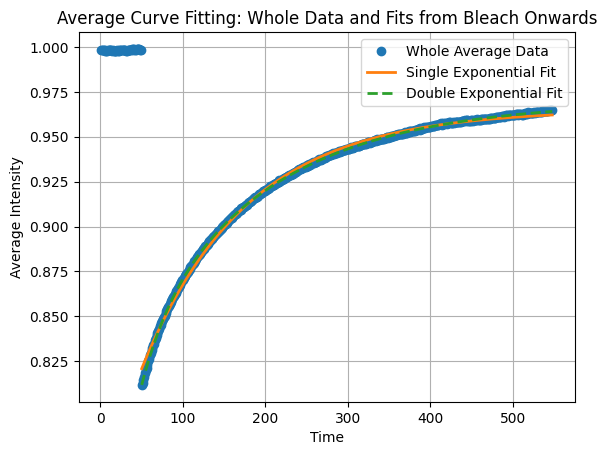

In [24]:
# Assuming the non-outlier runs are identified and outlier_runs is available
non_outlier_mask = ~outlier_runs  # Inverse mask for non-outliers
non_outlier_runs = [runs[i] for i in range(len(runs)) if non_outlier_mask[i]]
non_outlier_runs = np.array(non_outlier_runs)
# Get the time values (assuming the time axis is consistent across all runs)
time = Frame[50:]

# Calculate the average intensity, ignoring NaN values
average_intensity = np.nanmean(non_outlier_runs[:, 50:], axis=0)

# Extend time and intensity to include the initial prebleached phase
extended_time = np.concatenate([Frame[:50], time])
extended_average_intensity = np.concatenate([np.nanmean([run[:50] for run in non_outlier_runs], axis=0), average_intensity])

# Create a mask based on the valid (non-NaN) average intensity values
valid_mask = ~np.isnan(extended_average_intensity)

# Apply the mask to both time and average intensity to ensure they match in size
extended_time = extended_time[valid_mask]
extended_average_intensity = extended_average_intensity[valid_mask]

# Define indices to separate bleach phase and post-bleach phase
bleach_index = np.where(Frame == 50)[0][0]  # Adjust this if bleach phase index is different

# Fit the models to the average intensity from the bleach phase onwards
time_bleach = extended_time[bleach_index:]
average_intensity_bleach = extended_average_intensity[bleach_index:]

# Fit the single exponential model to the average curve
beta_single_avg, _ = curve_fit(exp_model_single, time_bleach, average_intensity_bleach,
                               p0=[min(average_intensity_bleach), max(average_intensity_bleach) - min(average_intensity_bleach), 100])

# Fit the double exponential model to the average curve
beta_double_avg, _ = curve_fit(exp_model_double, time_bleach, average_intensity_bleach,
                               p0=[min(average_intensity_bleach), (max(average_intensity_bleach) - min(average_intensity_bleach)) / 2, 30,
                                   (max(average_intensity_bleach) - min(average_intensity_bleach)) / 2, 150])

# Fit the triple exponential model to the average curve
bounds_avg = (0, [300, 300, 300, 300, 300, 300, 300])
beta_triple_avg, _ = curve_fit(exp_model_triple, time_bleach, average_intensity_bleach,
                               p0=[min(average_intensity_bleach), (max(average_intensity_bleach) - min(average_intensity_bleach)) / 3, 20,
                                   (max(average_intensity_bleach) - min(average_intensity_bleach)) / 3, 50,
                                   (max(average_intensity_bleach) - min(average_intensity_bleach)) / 3, 200],
                               bounds=bounds_avg)

# Calculate the fitted values for each model from the bleach phase onwards
fitted_intensity_single_avg = exp_model_single(extended_time, *beta_single_avg)
fitted_intensity_double_avg = exp_model_double(extended_time, *beta_double_avg)
fitted_intensity_triple_avg = exp_model_triple(extended_time, *beta_triple_avg)

# Calculate chi-squared values for the average curve fits
chisq_single_avg = np.sum((average_intensity_bleach - exp_model_single(time_bleach, *beta_single_avg)) ** 2)
chisq_double_avg = np.sum((average_intensity_bleach - exp_model_double(time_bleach, *beta_double_avg)) ** 2)
chisq_triple_avg = np.sum((average_intensity_bleach - exp_model_triple(time_bleach, *beta_triple_avg)) ** 2)

# Calculate AIC and AICc for the average curve fits
n_avg = len(time_bleach)
k_single_avg = 3
k_double_avg = 5
k_triple_avg = 7

aic_single_avg = n_avg * np.log(chisq_single_avg / n_avg) + 2 * k_single_avg
aic_double_avg = n_avg * np.log(chisq_double_avg / n_avg) + 2 * k_double_avg
aic_triple_avg = n_avg * np.log(chisq_triple_avg / n_avg) + 2 * k_triple_avg

aicc_single_avg = aic_single_avg + (2 * k_single_avg ** 2 + 2 * k_single_avg) / (n_avg - k_single_avg - 1)
aicc_double_avg = aic_double_avg + (2 * k_double_avg ** 2 + 2 * k_double_avg) / (n_avg - k_double_avg - 1)
aicc_triple_avg = aic_triple_avg + (2 * k_triple_avg ** 2 + 2 * k_triple_avg) / (n_avg - k_triple_avg - 1)

# Display the results for the average curve fitting
print('Results for Average Curve:')
print(f'Single Exponential: Tau = {beta_single_avg[2]}, A = {beta_single_avg[1]}, Chi-squared = {chisq_single_avg}, AICc = {aicc_single_avg}')
print(f'Double Exponential: Tau = {np.sort([beta_double_avg[2], beta_double_avg[4]])}, A = {np.sort([beta_double_avg[1], beta_double_avg[3]])}, Chi-squared = {chisq_double_avg}, AICc = {aicc_double_avg}')
print(f'Triple Exponential: Tau = {np.sort([beta_triple_avg[2], beta_triple_avg[4], beta_triple_avg[6]])}, A = {np.sort([beta_triple_avg[1], beta_triple_avg[3], beta_triple_avg[5]])}, Chi-squared = {chisq_triple_avg}, AICc = {aicc_triple_avg}')

# Plot the whole average curve and the fits from the bleach onwards
plt.figure()
plt.plot(extended_time, extended_average_intensity, 'o', label='Whole Average Data')
plt.plot(time_bleach, exp_model_single(time_bleach, *beta_single_avg), '-', label='Single Exponential Fit', linewidth=2)
plt.plot(time_bleach, exp_model_double(time_bleach, *beta_double_avg), '--', label='Double Exponential Fit', linewidth=2)
#plt.plot(time_bleach, exp_model_triple(time_bleach, *beta_triple_avg), '-.', label='Triple Exponential Fit', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Average Intensity')
plt.legend()
plt.title('Average Curve Fitting: Whole Data and Fits from Bleach Onwards')
plt.grid(True)
plt.show()


And now repeat this for the direct fitting:

Results for Average Curve (Direct Model):
Single Exponential: Tau = 127.12706751551589, A = 0.21363833844468094, Chi-squared = 0.0015747809860030644, AICc = -6314.407854298535
Double Exponential: Tau = [ 33.44990689 161.4608696 ], A = [0.14753841 0.17031851], Chi-squared = 6.025558367954823e-05, AICc = -7938.709479965527
Triple Exponential: Tau = [ 19.6185513   85.87262334 216.15612632], A = [0.20909708 0.11065429 0.10581138], Chi-squared = 4.40665292430241e-05, AICc = -8090.737544715537


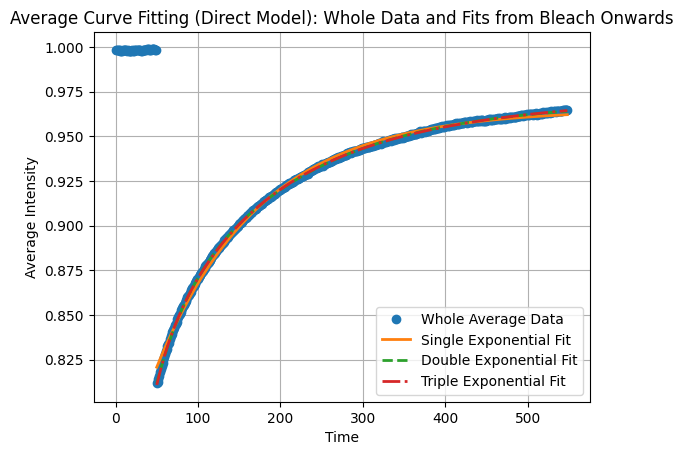

In [25]:
# Assuming the non-outlier runs are identified, and 'outlier_runs' is available as a boolean array
# Also assuming 'runs' is the array of intensity data, 'Frame' contains the time data, and non-outlier logic is in place

# Step 1: Mask for non-outlier runs
non_outlier_mask = ~outlier_runs  # Inverse mask for non-outliers
non_outlier_runs = [runs[i] for i in range(len(runs)) if non_outlier_mask[i]]
non_outlier_runs = np.array(non_outlier_runs)

# Step 2: Get the average intensity ignoring NaN values
average_intensity = np.nanmean(non_outlier_runs[:, 50:], axis=0)  # Average over the non-outlier runs
time = Frame[50:]

# Step 3: Extend time and intensity for prebleached phase
extended_time = np.concatenate([Frame[:50], time])
extended_average_intensity = np.concatenate([np.nanmean([run[:50] for run in non_outlier_runs], axis=0), average_intensity])

# Step 4: Create mask to remove NaN values
valid_mask = ~np.isnan(extended_average_intensity)
extended_time = extended_time[valid_mask]
extended_average_intensity = extended_average_intensity[valid_mask]

# Step 5: Identify bleach phase and post-bleach phase
bleach_index = np.where(Frame == 50)[0][0]
time_bleach = extended_time[bleach_index:]
average_intensity_bleach = extended_average_intensity[bleach_index:]

# Step 6: Initialize arrays for storing fit results for the average curve
tau_single_avg_direct = 0
A_single_avg_direct = 0
tau_double_avg_direct = np.zeros(2)
A_double_avg_direct = np.zeros(2)
tau_triple_avg_direct = np.zeros(3)
A_triple_avg_direct = np.zeros(3)

# Chi-squared and AICc values for the average curve fits
chisq_single_avg_direct = 0
chisq_double_avg_direct = 0
chisq_triple_avg_direct = 0

aicc_single_avg_direct = 0
aicc_double_avg_direct = 0
aicc_triple_avg_direct = 0

# Step 7: Fit direct models on average intensity data

# Single exponential model fitting for the average curve
beta_single_avg_direct, _ = curve_fit(
    exp_model_single, time_bleach, average_intensity_bleach,
    p0=[min(average_intensity_bleach), max(average_intensity_bleach) - min(average_intensity_bleach), 100]
)

# Double exponential model fitting for the average curve
beta_double_avg_direct, _ = curve_fit(
    exp_model_double, time_bleach, average_intensity_bleach,
    p0=[min(average_intensity_bleach), (max(average_intensity_bleach) - min(average_intensity_bleach)) / 2, 30,
        (max(average_intensity_bleach) - min(average_intensity_bleach)) / 2, 150]
)

# Triple exponential model fitting with constraints for the average curve
bounds_avg_direct = (0, [300, 300, 300, 300, 300, 300, 300])
beta_triple_avg_direct, _ = curve_fit(
    exp_model_triple, time_bleach, average_intensity_bleach,
    p0=[min(average_intensity_bleach), (max(average_intensity_bleach) - min(average_intensity_bleach)) / 3, 20,
        (max(average_intensity_bleach) - min(average_intensity_bleach)) / 3, 50,
        (max(average_intensity_bleach) - min(average_intensity_bleach)) / 3, 200],
    bounds=bounds_avg_direct
)

# Step 8: Extract tau and A values for the direct model fits
tau_single_avg_direct = beta_single_avg_direct[2]
A_single_avg_direct = beta_single_avg_direct[1]

tau_double_avg_direct = np.sort([beta_double_avg_direct[2], beta_double_avg_direct[4]])
A_double_avg_direct = np.array([beta_double_avg_direct[1], beta_double_avg_direct[3]])[np.argsort([beta_double_avg_direct[2], beta_double_avg_direct[4]])]

tau_triple_avg_direct = np.sort([beta_triple_avg_direct[2], beta_triple_avg_direct[4], beta_triple_avg_direct[6]])
A_triple_avg_direct = np.array([beta_triple_avg_direct[1], beta_triple_avg_direct[3], beta_triple_avg_direct[5]])[np.argsort([beta_triple_avg_direct[2], beta_triple_avg_direct[4], beta_triple_avg_direct[6]])]

# Step 9: Calculate chi-squared values for the direct model fits
fitted_intensity_single_avg_direct = exp_model_single(time_bleach, *beta_single_avg_direct)
fitted_intensity_double_avg_direct = exp_model_double(time_bleach, *beta_double_avg_direct)
fitted_intensity_triple_avg_direct = exp_model_triple(time_bleach, *beta_triple_avg_direct)

chisq_single_avg_direct = np.sum((average_intensity_bleach - fitted_intensity_single_avg_direct) ** 2)
chisq_double_avg_direct = np.sum((average_intensity_bleach - fitted_intensity_double_avg_direct) ** 2)
chisq_triple_avg_direct = np.sum((average_intensity_bleach - fitted_intensity_triple_avg_direct) ** 2)

# Step 10: Calculate AIC and AICc for the average curve fits
n_avg = len(time_bleach)
k_single_avg = 3
k_double_avg = 5
k_triple_avg = 7

aic_single_avg_direct = n_avg * np.log(chisq_single_avg_direct / n_avg) + 2 * k_single_avg
aic_double_avg_direct = n_avg * np.log(chisq_double_avg_direct / n_avg) + 2 * k_double_avg
aic_triple_avg_direct = n_avg * np.log(chisq_triple_avg_direct / n_avg) + 2 * k_triple_avg

aicc_single_avg_direct = aic_single_avg_direct + (2 * k_single_avg ** 2 + 2 * k_single_avg) / (n_avg - k_single_avg - 1)
aicc_double_avg_direct = aic_double_avg_direct + (2 * k_double_avg ** 2 + 2 * k_double_avg) / (n_avg - k_double_avg - 1)
aicc_triple_avg_direct = aic_triple_avg_direct + (2 * k_triple_avg ** 2 + 2 * k_triple_avg) / (n_avg - k_triple_avg - 1)

# Step 11: Display the results for the direct model fitting on the average curve
print('Results for Average Curve (Direct Model):')
print(f'Single Exponential: Tau = {tau_single_avg_direct}, A = {A_single_avg_direct}, Chi-squared = {chisq_single_avg_direct}, AICc = {aicc_single_avg_direct}')
print(f'Double Exponential: Tau = {tau_double_avg_direct}, A = {A_double_avg_direct}, Chi-squared = {chisq_double_avg_direct}, AICc = {aicc_double_avg_direct}')
print(f'Triple Exponential: Tau = {tau_triple_avg_direct}, A = {A_triple_avg_direct}, Chi-squared = {chisq_triple_avg_direct}, AICc = {aicc_triple_avg_direct}')

# Step 12: Plot the average curve and fits from bleach phase onwards
plt.figure()
plt.plot(extended_time, extended_average_intensity, 'o', label='Whole Average Data')
plt.plot(time_bleach, fitted_intensity_single_avg_direct, '-', label='Single Exponential Fit', linewidth=2)
plt.plot(time_bleach, fitted_intensity_double_avg_direct, '--', label='Double Exponential Fit', linewidth=2)
plt.plot(time_bleach, fitted_intensity_triple_avg_direct, '-.', label='Triple Exponential Fit', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Average Intensity')
plt.legend()
plt.title('Average Curve Fitting (Direct Model): Whole Data and Fits from Bleach Onwards')
plt.grid(True)
plt.show()


Now we need to plot all of the R values as a function of the number or runs. As usual, we start with the GBM approach:

Single exponential:

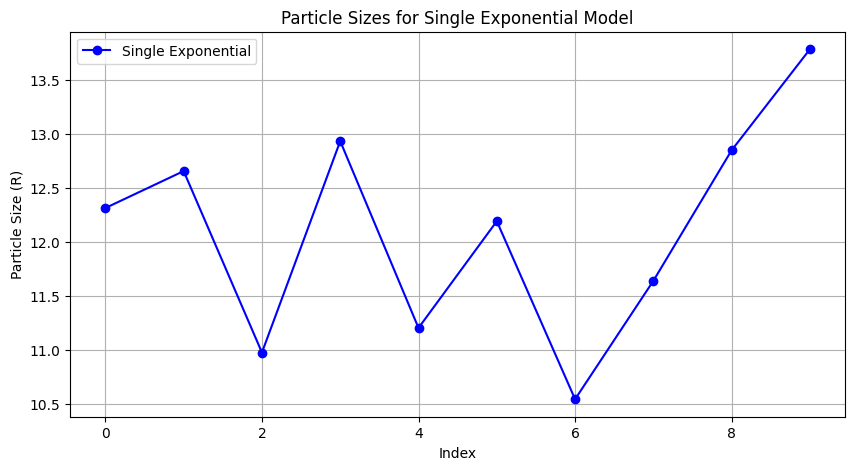

In [26]:
# Plot for Single Exponential Model
plt.figure(figsize=(10, 5))
plt.plot(R_single, 'o-', color='blue', label='Single Exponential')
plt.title('Particle Sizes for Single Exponential Model')
plt.xlabel('Index')
plt.ylabel('Particle Size (R)')
plt.legend()
plt.grid(True)
plt.show()



Double exponential:

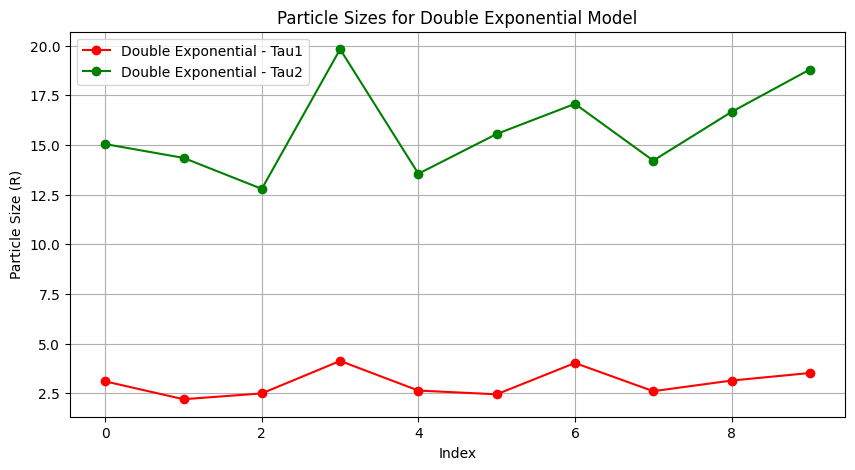

In [27]:

# Plot for Double Exponential Model
plt.figure(figsize=(10, 5))
plt.plot(R_double1, 'o-', color='red', label='Double Exponential - Tau1')
plt.plot(R_double2, 'o-', color='green', label='Double Exponential - Tau2')
plt.title('Particle Sizes for Double Exponential Model')
plt.xlabel('Index')
plt.ylabel('Particle Size (R)')
plt.legend()
plt.grid(True)
plt.show()


Triple exponential:

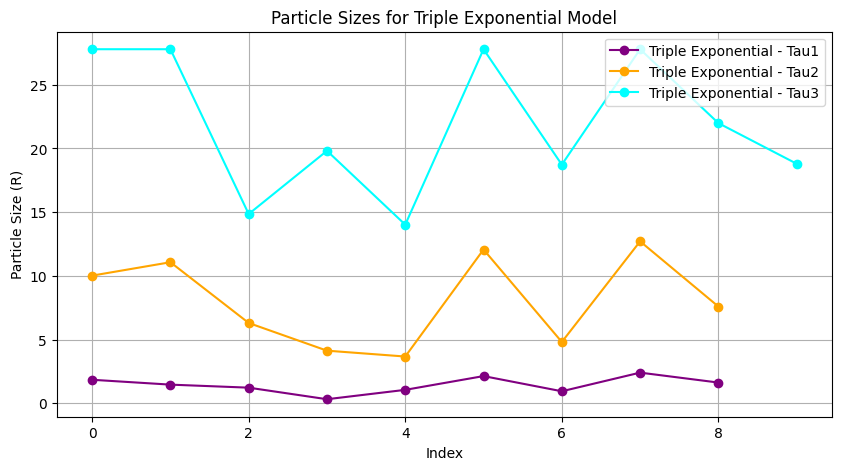

In [28]:

# Plot for Triple Exponential Model
plt.figure(figsize=(10, 5))
plt.plot(R_triple1, 'o-', color='purple', label='Triple Exponential - Tau1')
plt.plot(R_triple2, 'o-', color='orange', label='Triple Exponential - Tau2')
plt.plot(R_triple3, 'o-', color='cyan', label='Triple Exponential - Tau3')
plt.title('Particle Sizes for Triple Exponential Model')
plt.xlabel('Index')
plt.ylabel('Particle Size (R)')
plt.legend()
plt.grid(True)
plt.show()

And we repeat the process for the direct fitting.
Single exponential:

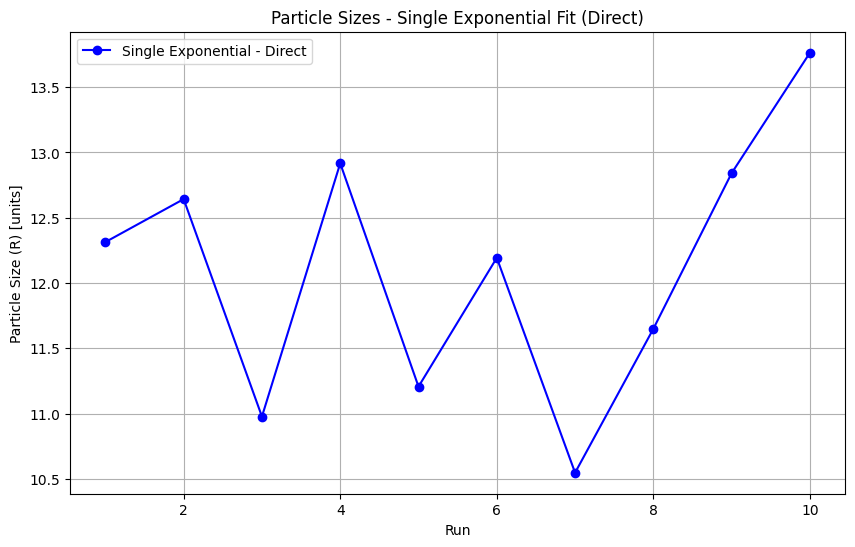

In [29]:
# Define the x-axis (run indices) 
runs = np.arange(1, len(R_single_direct) + 1)

# Plot for Single Exponential (non-outliers) - Direct Fitting
plt.figure(figsize=(10, 6))
plt.plot(runs, R_single_direct, 'o-', label="Single Exponential - Direct", color='b')
plt.title('Particle Sizes - Single Exponential Fit (Direct)')
plt.xlabel('Run')
plt.ylabel('Particle Size (R) [units]')
plt.grid(True)
plt.legend()
plt.show()

Double exponential:

Length of runs: 10
Length of R_double1_direct: 10
Length of R_double2_direct: 10


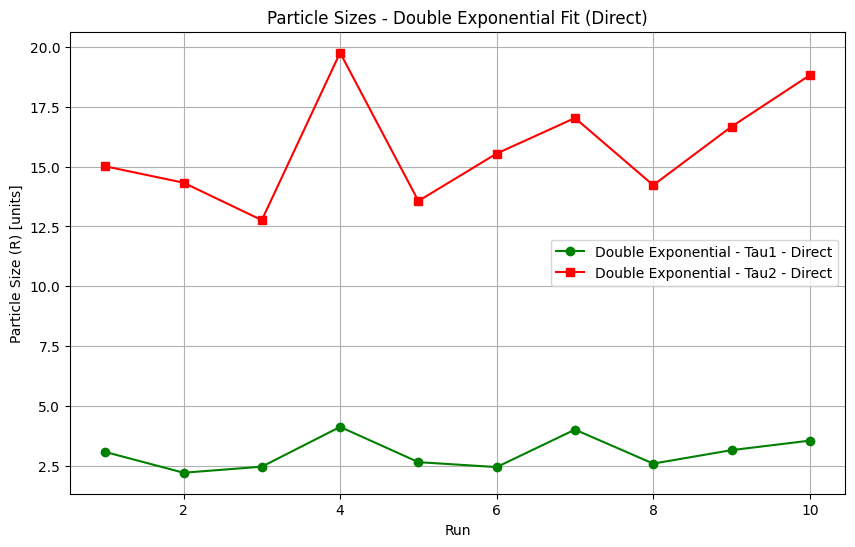

In [30]:
# Check the lengths of runs and R_double1_direct, R_double2_direct
print(f'Length of runs: {len(runs)}')
print(f'Length of R_double1_direct: {len(R_double1_direct)}')
print(f'Length of R_double2_direct: {len(R_double2_direct)}')

# If they are not equal, make sure to filter runs based on valid data points
min_len = min(len(runs), len(R_double1_direct), len(R_double2_direct))

# Slice arrays to the minimum length to match dimensions
runs_filtered = runs[:min_len]
R_double1_direct_filtered = R_double1_direct[:min_len]
R_double2_direct_filtered = R_double2_direct[:min_len]

# Now plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(runs_filtered, R_double1_direct_filtered, 'o-', label="Double Exponential - Tau1 - Direct", color='g')
plt.plot(runs_filtered, R_double2_direct_filtered, 's-', label="Double Exponential - Tau2 - Direct", color='r')
plt.title('Particle Sizes - Double Exponential Fit (Direct)')
plt.xlabel('Run')
plt.ylabel('Particle Size (R) [units]')
plt.grid(True)
plt.legend()
plt.show()


Triple Exponential:

Length of runs: 10
Length of R_triple1_direct: 9
Length of R_triple2_direct: 10
Length of R_triple3_direct: 10


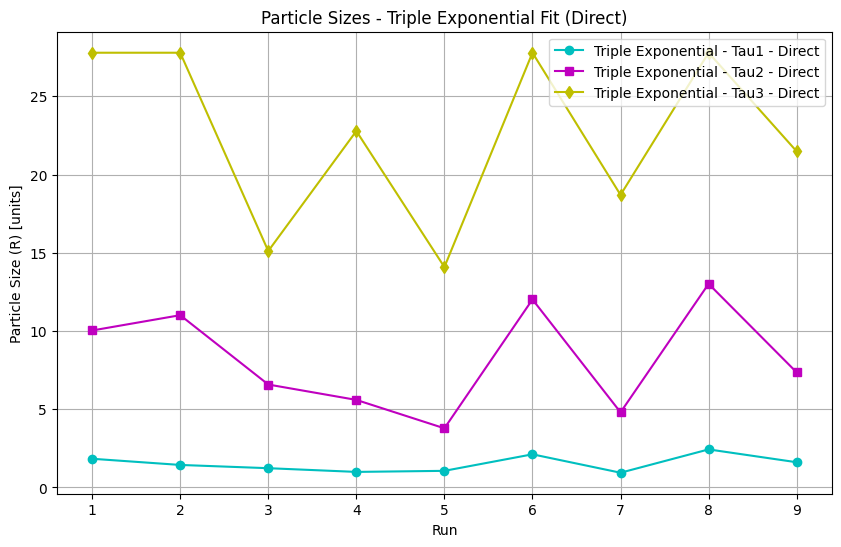

In [31]:
# Check the lengths of runs and R_triple1_direct, R_triple2_direct, R_triple3_direct
print(f'Length of runs: {len(runs)}')
print(f'Length of R_triple1_direct: {len(R_triple1_direct)}')
print(f'Length of R_triple2_direct: {len(R_triple2_direct)}')
print(f'Length of R_triple3_direct: {len(R_triple3_direct)}')

# Ensure lengths match by filtering to the minimum length
min_len = min(len(runs), len(R_triple1_direct), len(R_triple2_direct), len(R_triple3_direct))

# Slice arrays to the minimum length to match dimensions
runs_filtered = runs[:min_len]
R_triple1_direct_filtered = R_triple1_direct[:min_len]
R_triple2_direct_filtered = R_triple2_direct[:min_len]
R_triple3_direct_filtered = R_triple3_direct[:min_len]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(runs_filtered, R_triple1_direct_filtered, 'o-', label="Triple Exponential - Tau1 - Direct", color='c')
plt.plot(runs_filtered, R_triple2_direct_filtered, 's-', label="Triple Exponential - Tau2 - Direct", color='m')
plt.plot(runs_filtered, R_triple3_direct_filtered, 'd-', label="Triple Exponential - Tau3 - Direct", color='y')
plt.title('Particle Sizes - Triple Exponential Fit (Direct)')
plt.xlabel('Run')
plt.ylabel('Particle Size (R) [units]')
plt.grid(True)
plt.legend()
plt.show()


Error bar test:

In [32]:
# Calculate standard deviations of the particle size values
std_R_single = np.std(R_single)
std_R_double1 = np.std(R_double1)
std_R_double2 = np.std(R_double2)
std_R_triple1 = np.std(R_triple1)
std_R_triple2 = np.std(R_triple2)
std_R_triple3 = np.std(R_triple3)

# Convert standard deviations to nanometers
std_R_single_nm = std_R_single 
std_R_double1_nm = std_R_double1 
std_R_double2_nm = std_R_double2 
std_R_triple1_nm = std_R_triple1 
std_R_triple2_nm = std_R_triple2 
std_R_triple3_nm = std_R_triple3 

# Print results
print(f'Standard deviation of R_single: {std_R_single_nm:.2f} nm')
print(f'Standard deviation of R_double1: {std_R_double1_nm:.2f} nm')
print(f'Standard deviation of R_double2: {std_R_double2_nm:.2f} nm')
print(f'Standard deviation of R_triple1: {std_R_triple1_nm:.2f} nm')
print(f'Standard deviation of R_triple2: {std_R_triple2_nm:.2f} nm')
print(f'Standard deviation of R_triple3: {std_R_triple3_nm:.2f} nm')

Standard deviation of R_single: 0.96 nm
Standard deviation of R_double1: 0.64 nm
Standard deviation of R_double2: 2.16 nm
Standard deviation of R_triple1: 0.61 nm
Standard deviation of R_triple2: 3.32 nm
Standard deviation of R_triple3: 5.24 nm


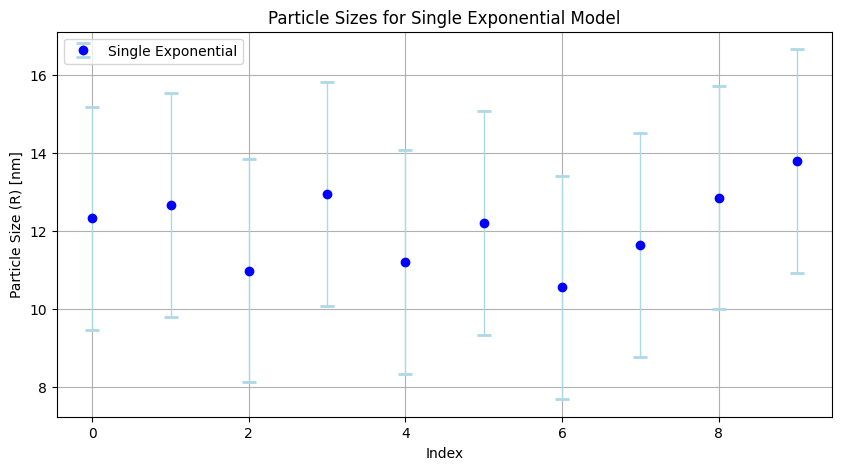

In [33]:
# Calculate error bars (3 standard deviations)
error_R_single = 3 * std_R_single  # Error bars in meters
error_R_single_nm = error_R_single  # Convert to nanometers

# Plot for Single Exponential Model with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(R_single)), R_single , yerr=error_R_single_nm, fmt='o', color='blue', 
             label='Single Exponential', ecolor='lightblue', capsize=5, capthick=2, elinewidth=1)
plt.title('Particle Sizes for Single Exponential Model')
plt.xlabel('Index')
plt.ylabel('Particle Size (R) [nm]')
plt.legend()
plt.grid(True)
plt.show()

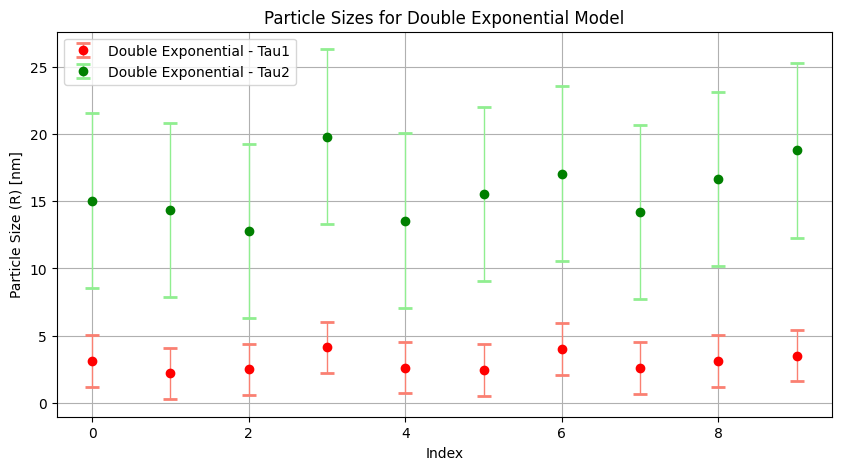

In [34]:
# Convert standard deviations to nanometers
std_R_double1_nm = std_R_double1 
std_R_double2_nm = std_R_double2 

# Calculate error bars (3 standard deviations)
error_R_double1 = 3 * std_R_double1  # Error bars in meters
error_R_double2 = 3 * std_R_double2  # Error bars in meters

error_R_double1_nm = error_R_double1   # Convert to nanometers
error_R_double2_nm = error_R_double2   # Convert to nanometers

# Plot for Double Exponential Model with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(R_double1)), R_double1 , yerr=error_R_double1_nm, fmt='o', color='red', 
             label='Double Exponential - Tau1', ecolor='salmon', capsize=5, capthick=2, elinewidth=1)
plt.errorbar(range(len(R_double2)), R_double2 , yerr=error_R_double2_nm, fmt='o', color='green', 
             label='Double Exponential - Tau2', ecolor='lightgreen', capsize=5, capthick=2, elinewidth=1)
plt.title('Particle Sizes for Double Exponential Model')
plt.xlabel('Index')
plt.ylabel('Particle Size (R) [nm]')
plt.legend()
plt.grid(True)
plt.show()

what is left is to play with the error bars. USe all three methods suggested by ChatGPT and check which one is the best. Then update the fitting parts of the notebook and we should be done with a real workhorse of a script! :)

Change of opinion. Calculate all three metric without error bars for now and then discuss with Yu Chen which 

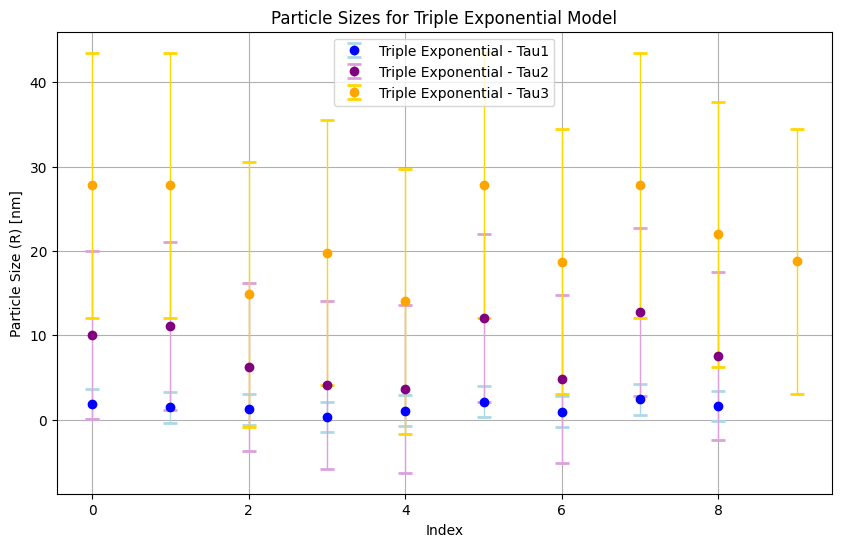

In [35]:
# Convert standard deviations to nanometers
std_R_triple1_nm = std_R_triple1 
std_R_triple2_nm = std_R_triple2 
std_R_triple3_nm = std_R_triple3 

# Calculate error bars (3 standard deviations)
error_R_triple1 = 3 * std_R_triple1  # Error bars in meters
error_R_triple2 = 3 * std_R_triple2  # Error bars in meters
error_R_triple3 = 3 * std_R_triple3  # Error bars in meters


error_R_triple1_nm = error_R_triple1   # Convert to nanometers
error_R_triple2_nm = error_R_triple2   # Convert to nanometers
error_R_triple3_nm = error_R_triple3   # Convert to nanometers

# Plot for Triple Exponential Model with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(R_triple1)), R_triple1, yerr=error_R_triple1_nm, fmt='o', color='blue', 
             label='Triple Exponential - Tau1', ecolor='lightblue', capsize=5, capthick=2, elinewidth=1)
plt.errorbar(range(len(R_triple2)), R_triple2, yerr=error_R_triple2_nm, fmt='o', color='purple', 
             label='Triple Exponential - Tau2', ecolor='plum', capsize=5, capthick=2, elinewidth=1)
plt.errorbar(range(len(R_triple3)), R_triple3, yerr=error_R_triple3_nm, fmt='o', color='orange', 
             label='Triple Exponential - Tau3', ecolor='gold', capsize=5, capthick=2, elinewidth=1)

# Plot formatting
plt.title('Particle Sizes for Triple Exponential Model')
plt.xlabel('Index')
plt.ylabel('Particle Size (R) [nm]')
plt.legend()
plt.grid(True)
plt.show()